In [541]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import math
import pandas as pd
from scipy.optimize import curve_fit
import numpy.polynomial.polynomial as poly
import emcee
import corner
from scipy.optimize import minimize
from IPython.display import display, Math
import matplotlib as mpl
from multiprocessing.pool import Pool
from mcmc_functions import *
import pickle
import h5py
import glob
import os
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import astropy.units as u
import astropy.cosmology.units as cu
from astropy.cosmology import WMAP9

SAVE_DIR = './mcmc_fp_results/'

In [542]:
# read in the subselected dataframes created when running mcmc script
snztf18 = pd.read_csv('./mcmc_fp_results/subselected_dfs/snztf18.csv')
sn19rwd = pd.read_csv('./mcmc_fp_results/subselected_dfs/sn19rwd.csv')
sn20ano = pd.read_csv('./mcmc_fp_results/subselected_dfs/sn20ano.csv',)
sn20bio = pd.read_csv('./mcmc_fp_results/subselected_dfs/sn20bio.csv')
sn20ikq = pd.read_csv('./mcmc_fp_results/subselected_dfs/sn20ikq.csv',)
sn20rsc = pd.read_csv('./mcmc_fp_results/subselected_dfs/sn20rsc.csv',)
# sn21aezx = pd.read_csv('./mcmc_fp_results/subselected_dfs/sn21aezx.csv')
sn21gno = pd.read_csv('./mcmc_fp_results/subselected_dfs/sn21gno.csv')
sn21heh = pd.read_csv('./mcmc_fp_results/subselected_dfs/sn21heh.csv')
sn21pb = pd.read_csv('./mcmc_fp_results/subselected_dfs/sn21pb.csv')
sn21vgn = pd.read_csv('./mcmc_fp_results/subselected_dfs/sn21vgn.csv')
sn22hnt = pd.read_csv('./mcmc_fp_results/subselected_dfs/sn22hnt.csv')
sn22jpx = pd.read_csv('./mcmc_fp_results/subselected_dfs/sn22jpx.csv')
sn22qzr = pd.read_csv('./mcmc_fp_results/subselected_dfs/sn22qzr.csv')
sn22qzr.columns

Index(['JD', 'filter', 'mag', 'ztf_mag_lower', 'ztf_mag_upper',
       'atlas_mag_err', 'data_origin', 'norm_t', 'norm_m', 'max_ztf_err',
       'mag_err_all'],
      dtype='object')

In [543]:
df_str_list = ['snztf18','sn19rwd','sn20ano','sn20bio','sn20ikq','sn20rsc','sn21gno','sn21heh','sn21pb','sn21vgn','sn22hnt','sn22jpx','sn22qzr']
df_sub_ls = [snztf18,sn19rwd,sn20ano,sn20bio,sn20ikq,sn20rsc,sn21gno,sn21heh,sn21pb,sn21vgn,sn22hnt,sn22jpx,sn22qzr]
plot_names = ['ZTF18aalrxas', '19rwd', '20ano','20bio','20ikq','20rsc','21gno','21heh','21pb','21vgn','22hnt','22jpx','22qzr']

In [544]:
#reading in app to abs mag conversion table generated in temp/cadence_template.ipynb
mag_conversion_df = pd.read_csv('./data/mag_conversion_factors.csv')

In [545]:
#calculating how much each sub_selected light curve was shifted when normalizing magnitude (used to calc abs mag later)
a2_inds = [52, 25, 68, 21, 58, 27, 9, 10, 29, 70, 11, 51, 2]

mag_shifts, mjds_a2 = [],[]
for i,df in enumerate(df_sub_ls):
    shift = df['mag'].loc[a2_inds[i]]
    mag_shifts.append(shift)
    #
    a2_t = df['JD'].loc[a2_inds[i]] #time
    norm_t = ((df['JD']) - a2_t)+15
    df['norm_t'] = norm_t
    mjds_a2.append(a2_t - 2400000.5)

mag_conversion_df['norm_mag_shift'] = mag_shifts
mag_conversion_df['mjd_at_a2'] = mjds_a2
mag_conversion_df

,sn,ext_g,ext_r,mag_conversion,norm_mag_shift,mjd_at_a2
0,snztf18,0.024368,0.016695,37.161198,20.592843,58236.356887
1,sn19rwd,0.082553,0.057517,34.342376,18.741828,58768.308449
2,sn20ano,0.024123,0.016708,35.664306,21.164587,58877.469005
3,sn20bio,0.011505,0.008043,32.378356,17.548000,58884.595686
4,sn20ikq,0.013431,0.009277,36.089684,19.297000,58981.390030
5,sn20rsc,0.057619,0.039906,35.676230,20.733649,59085.469688
6,sn21gno,0.041688,0.029180,32.421499,18.260761,59298.394757
7,sn21heh,0.041623,0.028883,35.382436,19.243058,59310.222824
8,sn21pb,0.013012,0.009005,35.804631,19.998000,59226.512787
9,sn21vgn,0.018275,0.012651,35.748484,19.024000,59443.308147


In [546]:
r1_bool_dict = {
        "g": {"snztf18":True,
              "sn19rwd":True,
              "sn20bio":True,
              "sn21gno":True,
              "sn21heh":True,
              "sn21vgn":True,
              'sn22hnt':False,
              'sn22jpx':False,
              'sn22qzr':False,
              'sn20ano':True,
              'sn20ikq':True,
              'sn20rsc':True,
              'sn21pb':False},
        "r": {"snztf18":True,
              "sn19rwd":True,
              "sn20bio":True,
              "sn21gno":True,
              "sn21heh":True,
              "sn21vgn":True,
              'sn22hnt':True,
              'sn22jpx':True,
              'sn22qzr':True,
              'sn20ano':True,
              'sn20ikq':True,
              'sn20rsc':True,
              'sn21pb':True}
    }

In [483]:
# if code crashes, reload the chains here to find bestfit
g_chains = []
r_chains = []
for i in range(len(df_str_list)):
    save_dir = './mcmc_fp_results/flatchains/'
    gf = save_dir+df_str_list[i]+'_g_flatchains.txt'
    rf = save_dir+df_str_list[i]+'_r_flatchains.txt'
    g_chains.append(gf)
    r_chains.append(rf)

def bestfit_recovery(filename, sub_df, band='', r1_bool=True, sn_id_band='test_g', replot=False):
    flat_samples = np.loadtxt(filename)
    if r1_bool:
        ndim = 7
    if not r1_bool:
        ndim = 5

    mcmc_results = []
    #retrieve the 16th/50th/84th percentile for each param and the lower/upper bounds on each
    for i in range(ndim):
        mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
        q = np.diff(mcmc)
        arr = [mcmc[1], q[0], q[1]]
        mcmc_results.append(arr)

    # making fit/autocorr/corner plots
    if band == 'g':
        g_df = sub_df[(sub_df['filter']=='ZTF_g') | (sub_df['filter']=='c')]
        x,y,yerr = np.array(g_df['norm_t']),np.array(g_df['norm_m']),np.array(g_df['mag_err_all'])
    if band == 'r':
        r_df = sub_df[(sub_df['filter']=='ZTF_r') | (sub_df['filter']=='o')]
        x,y,yerr = np.array(r_df['norm_t']),np.array(r_df['norm_m']),np.array(r_df['mag_err_all'])
    if replot:
        plot_mcmc_results(x, y, yerr, mcmc_results, flat_samples, r1=r1_bool, sn_band=sn_id_band, save=True)
        do_gw_autocorr_and_plot(filename, sn_id_band)

    return mcmc_results#,flat_samples

In [484]:
all_fits_g = [] # shape (13, 7, 3) (nobjects, nparams, npercentiles)
for i,file in enumerate(g_chains):
    fit = bestfit_recovery(file, df_sub_ls[i], band='g', r1_bool=r1_bool_dict['g'][df_str_list[i]],sn_id_band=df_str_list[i]+'_g')
    all_fits_g.append(fit)

In [485]:
all_fits_r = [] # shape (13, 7, 3) (nobjects, nparams, npercentiles)
for i,file in enumerate(r_chains):
    fit = bestfit_recovery(file, df_sub_ls[i], band='r', r1_bool=r1_bool_dict['r'][df_str_list[i]],sn_id_band=df_str_list[i]+'_r')
    all_fits_r.append(fit)

In [486]:
with open(SAVE_DIR+'bestfits_g.npy', 'wb') as f:
    np.save(f, np.array(all_fits_g))
f.close

/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_58638/1848714995.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save(f, np.array(all_fits_g))


<function BufferedWriter.close>

In [487]:
with open(SAVE_DIR+'bestfits_r.npy', 'wb') as f:
    np.save(f, np.array(all_fits_r))
f.close

<function BufferedWriter.close>

In [514]:
#the next two loops separate out the indivudal param values and append to list to do stats on them
best_fits_g,best_fits_r = [],[]
low_err_g, upp_err_g =[],[]
low_err_r, upp_err_r =[],[]
for i in range(len(all_fits_r)):
    #g band
    bestg = np.array(all_fits_g[i]).T[0]  #bestfit (50% ptile) values
    lowg = np.array(all_fits_g[i]).T[1]   #lower bound, 16% ptile
    highg =  np.array(all_fits_g[i]).T[2] #upper bound, 84% ptile
    best_fits_g.append(bestg)
    low_err_g.append(lowg)
    upp_err_g.append(highg)

    #r band
    bestr = np.array(all_fits_r[i]).T[0]  #bestfit (50% ptile) values
    lowr = np.array(all_fits_r[i]).T[1]   #lower bound, 16% ptile
    highr =  np.array(all_fits_r[i]).T[2] #upper bound, 84% ptile
    best_fits_r.append(bestr)
    low_err_r.append(lowr)
    upp_err_r.append(highr)

# formatting and saving best fits values in g and r
best_fits_g_same_len = []
for i,arr in enumerate(best_fits_g):
    if len(arr) == 5:
        arr = np.insert(arr, [0,3], np.nan)
    best_fits_g_same_len.append(arr)

best_fits_r_same_len = []
for i,arr in enumerate(best_fits_r):
    if len(arr) == 5:
        arr = np.insert(arr, [0,3], np.nan)
    best_fits_r_same_len.append(arr)

#saving to df
best_fits_cols_g = ['m1_g', 'm2_g', 'm3_g', 'b2_g', 'a1_g', 'a2_g', 'log_f_g']
best_fits_cols_r = ['m1_r', 'm2_r', 'm3_r', 'b2_r', 'a1_r', 'a2_r', 'log_f_r']
bestfit_df = pd.DataFrame(columns=best_fits_cols_g, data=best_fits_g_same_len)
bestfit_r_df = pd.DataFrame(columns=best_fits_cols_r, data=best_fits_r_same_len)
bestfit_df.insert(0,'SN_ID', df_str_list)
bestfit_df = pd.concat([bestfit_df,bestfit_r_df], axis=1)
bestfit_df

,SN_ID,m1_g,m2_g,m3_g,b2_g,a1_g,a2_g,log_f_g,m1_r,m2_r,m3_r,b2_r,a1_r,a2_r,log_f_r
0,snztf18,-1.453288,0.268554,-0.052926,-3.864192,6.714141,13.107969,-3.746322,-1.653940,0.115683,-0.073302,-2.350598,7.663041,15.613060,-3.564006
1,sn19rwd,-0.979590,0.142178,-0.049146,-1.921088,8.261812,14.163972,-2.701529,-0.514944,0.091144,-0.029224,-1.386172,8.728792,13.820153,-1.902896
2,sn20ano,-0.606980,0.382998,-0.088906,-5.203419,9.180605,14.371975,-0.533924,-0.715000,0.299137,-0.084340,-4.335608,8.722938,13.916714,-3.500523
3,sn20bio,-0.679592,0.187333,-0.183369,-2.579680,9.410125,14.717309,1.364686,-0.805282,0.282817,-0.133987,-3.897599,9.193014,16.188675,-3.466265
4,sn20ikq,-1.107506,0.107934,-0.003755,-1.651887,2.241731,14.641405,-1.418653,-0.960401,0.034754,-0.003679,-0.828949,1.582649,15.622305,-1.472611
5,sn20rsc,-1.542456,0.364869,-0.036975,-5.069791,10.071302,17.606733,-1.621135,-0.962749,0.242947,-0.062612,-3.515344,10.101722,16.254400,0.209470
6,sn21gno,-1.589472,0.151964,-0.089391,-2.115394,9.798067,13.929084,-1.423370,-1.115765,0.119778,-0.105575,-1.871648,10.381562,13.481051,-2.602094
7,sn21heh,-1.018082,0.165181,-0.073015,-2.609369,2.694032,14.985388,-1.329173,-0.433238,0.137601,-0.059142,-2.657557,4.501014,13.922081,-2.373261
8,sn21pb,NaN,0.231304,-0.117904,-3.303867,NaN,13.760906,-1.540608,-0.837429,0.150080,-0.125843,-2.440361,8.766434,14.156986,-1.762168
9,sn21vgn,-0.857860,0.206177,-0.064994,-2.372771,7.236515,13.527217,-1.622646,-1.602391,0.166318,-0.059288,-2.048997,7.264507,13.407664,-0.335258


In [515]:
#same sn, same lc, same filters, diff params
bestfit_df['a2g-a1g'] = bestfit_df['a2_g'] - bestfit_df['a1_g']
bestfit_df['a2r-a1r'] = bestfit_df['a2_r'] - bestfit_df['a1_r']
#same sn, diff lc, diff filters, same params
bestfit_df['a1g-a1r'] = bestfit_df['a1_g'] - bestfit_df['a1_r']
bestfit_df['a2g-a2r'] = bestfit_df['a2_g'] - bestfit_df['a2_r']
bestfit_df

,SN_ID,m1_g,m2_g,m3_g,b2_g,a1_g,a2_g,log_f_g,m1_r,m2_r,m3_r,b2_r,a1_r,a2_r,log_f_r,a2g-a1g,a2r-a1r,a1g-a1r,a2g-a2r
0,snztf18,-1.453288,0.268554,-0.052926,-3.864192,6.714141,13.107969,-3.746322,-1.653940,0.115683,-0.073302,-2.350598,7.663041,15.613060,-3.564006,6.393828,7.950019,-0.948900,-2.505090
1,sn19rwd,-0.979590,0.142178,-0.049146,-1.921088,8.261812,14.163972,-2.701529,-0.514944,0.091144,-0.029224,-1.386172,8.728792,13.820153,-1.902896,5.902160,5.091361,-0.466980,0.343819
2,sn20ano,-0.606980,0.382998,-0.088906,-5.203419,9.180605,14.371975,-0.533924,-0.715000,0.299137,-0.084340,-4.335608,8.722938,13.916714,-3.500523,5.191370,5.193776,0.457667,0.455261
3,sn20bio,-0.679592,0.187333,-0.183369,-2.579680,9.410125,14.717309,1.364686,-0.805282,0.282817,-0.133987,-3.897599,9.193014,16.188675,-3.466265,5.307184,6.995661,0.217111,-1.471366
4,sn20ikq,-1.107506,0.107934,-0.003755,-1.651887,2.241731,14.641405,-1.418653,-0.960401,0.034754,-0.003679,-0.828949,1.582649,15.622305,-1.472611,12.399674,14.039656,0.659082,-0.980899
5,sn20rsc,-1.542456,0.364869,-0.036975,-5.069791,10.071302,17.606733,-1.621135,-0.962749,0.242947,-0.062612,-3.515344,10.101722,16.254400,0.209470,7.535430,6.152678,-0.030420,1.352333
6,sn21gno,-1.589472,0.151964,-0.089391,-2.115394,9.798067,13.929084,-1.423370,-1.115765,0.119778,-0.105575,-1.871648,10.381562,13.481051,-2.602094,4.131018,3.099489,-0.583495,0.448034
7,sn21heh,-1.018082,0.165181,-0.073015,-2.609369,2.694032,14.985388,-1.329173,-0.433238,0.137601,-0.059142,-2.657557,4.501014,13.922081,-2.373261,12.291356,9.421067,-1.806982,1.063307
8,sn21pb,NaN,0.231304,-0.117904,-3.303867,NaN,13.760906,-1.540608,-0.837429,0.150080,-0.125843,-2.440361,8.766434,14.156986,-1.762168,NaN,5.390552,NaN,-0.396080
9,sn21vgn,-0.857860,0.206177,-0.064994,-2.372771,7.236515,13.527217,-1.622646,-1.602391,0.166318,-0.059288,-2.048997,7.264507,13.407664,-0.335258,6.290702,6.143158,-0.027992,0.119553


In [516]:
#calculate t_1/2 from individual mcmc fits, ONLY FOR R-BAND

def calc_t_half(df_sub, df_str):
    df_sub = df_sub.sort_values(by='norm_t')
    rband = (df_sub['filter']=='ZTF_r') | (df_sub['filter']=='o')
    
    min_t = df_sub.loc[rband,'norm_t'].min()
    best_df = bestfit_df.loc[bestfit_df['SN_ID']==df_str]

    #calc time above half max for SCE peak
    ta1 = best_df.a1_r                    #time of a1, SCE peak
    taa1 = best_df['a2r-a1r']/2 + ta1     #time halfway b/w a1 and a2
    tba1 = ta1 - (ta1-min_t)/2            #time halfway b/w start and a1
    t_half = (taa1-tba1).item()
    #add to bestfit_df
    bestfit_df.loc[bestfit_df['SN_ID']==df_str, 't_half-r'] = t_half

    # calc abs mag of SCE peak (a1)
    x_list = np.arange(min_t,df_sub.loc[rband,'norm_t'].max(),0.01)
    best = best_df[['m1_r','m2_r','m3_r','b2_r','a1_r','a2_r','log_f_r']].iloc[0].to_numpy()
    a1_index = np.abs(x_list - ta1.values).argmin()
    app_mag_a1 = np.array([model(best, v, r1=r1_bool_dict['r'][df_str]) for v in x_list])[a1_index] + mag_conversion_df.loc[mag_conversion_df['sn']==df_str].norm_mag_shift.iloc[0]
    abs_mag_a1 = (app_mag_a1 - mag_conversion_df.loc[mag_conversion_df['sn']==df_str].mag_conversion.iloc[0] - 
                  mag_conversion_df.loc[mag_conversion_df['sn']==df_str].ext_r.iloc[0])
    bestfit_df.loc[bestfit_df['SN_ID']==df_str, 'a1_abs_mag-r'] = abs_mag_a1
    
    return #t_half, abs_mag_a1

In [517]:
for i,df in enumerate(df_sub_ls):
    calc_t_half(df, df_str_list[i])
bestfit_df

,SN_ID,m1_g,m2_g,m3_g,b2_g,a1_g,a2_g,log_f_g,m1_r,m2_r,...,b2_r,a1_r,a2_r,log_f_r,a2g-a1g,a2r-a1r,a1g-a1r,a2g-a2r,t_half-r,a1_abs_mag-r
0,snztf18,-1.453288,0.268554,-0.052926,-3.864192,6.714141,13.107969,-3.746322,-1.653940,0.115683,...,-2.350598,7.663041,15.613060,-3.564006,6.393828,7.950019,-0.948900,-2.505090,5.315673,-18.046965
1,sn19rwd,-0.979590,0.142178,-0.049146,-1.921088,8.261812,14.163972,-2.701529,-0.514944,0.091144,...,-1.386172,8.728792,13.820153,-1.902896,5.902160,5.091361,-0.466980,0.343819,3.490053,-16.248550
2,sn20ano,-0.606980,0.382998,-0.088906,-5.203419,9.180605,14.371975,-0.533924,-0.715000,0.299137,...,-4.335608,8.722938,13.916714,-3.500523,5.191370,5.193776,0.457667,0.455261,3.879967,-16.241535
3,sn20bio,-0.679592,0.187333,-0.183369,-2.579680,9.410125,14.717309,1.364686,-0.805282,0.282817,...,-3.897599,9.193014,16.188675,-3.466265,5.307184,6.995661,0.217111,-1.471366,3.628795,-16.134505
4,sn20ikq,-1.107506,0.107934,-0.003755,-1.651887,2.241731,14.641405,-1.418653,-0.960401,0.034754,...,-0.828949,1.582649,15.622305,-1.472611,12.399674,14.039656,0.659082,-0.980899,8.283516,-17.575816
5,sn20rsc,-1.542456,0.364869,-0.036975,-5.069791,10.071302,17.606733,-1.621135,-0.962749,0.242947,...,-3.515344,10.101722,16.254400,0.209470,7.535430,6.152678,-0.030420,1.352333,3.655082,-16.043037
6,sn21gno,-1.589472,0.151964,-0.089391,-2.115394,9.798067,13.929084,-1.423370,-1.115765,0.119778,...,-1.871648,10.381562,13.481051,-2.602094,4.131018,3.099489,-0.583495,0.448034,2.760791,-14.815750
7,sn21heh,-1.018082,0.165181,-0.073015,-2.609369,2.694032,14.985388,-1.329173,-0.433238,0.137601,...,-2.657557,4.501014,13.922081,-2.373261,12.291356,9.421067,-1.806982,1.063307,4.899552,-18.206206
8,sn21pb,NaN,0.231304,-0.117904,-3.303867,NaN,13.760906,-1.540608,-0.837429,0.150080,...,-2.440361,8.766434,14.156986,-1.762168,NaN,5.390552,NaN,-0.396080,3.565412,-16.940105
9,sn21vgn,-0.857860,0.206177,-0.064994,-2.372771,7.236515,13.527217,-1.622646,-1.602391,0.166318,...,-2.048997,7.264507,13.407664,-0.335258,6.290702,6.143158,-0.027992,0.119553,5.176878,-17.576960


In [518]:
#finding the model mag at bestfit: a1/a2 for each band

m_a2g_a1g_ls, m_a2r_a1r_ls, m_a1g_a1r_ls, m_a2g_a2r_ls = [],[],[],[]
for i,df in enumerate(df_sub_ls):
    df_str = df_str_list[i]

    #gband
    g_df = df[(df['filter']=='ZTF_g') | (df['filter']=='c')]
    x_plt_g = np.arange(min(g_df['norm_t']),max(g_df['norm_t']),0.01)
    sn_g = bestfit_df.loc[:,bestfit_df.columns.str[-2:]=='_g'].loc[i]
    sn_g = sn_g.loc[sn_g.notna()].to_numpy()
    a1_g, a2_g = bestfit_df['a1_g'].loc[i], bestfit_df['a2_g'].loc[i]
    a1crit_g = np.abs(x_plt_g - a1_g).argmin()
    a2crit_g = np.abs(x_plt_g - a2_g).argmin()

    mags_g = np.array([model(sn_g, v, r1=r1_bool_dict['g'][df_str]) for v in x_plt_g])
    a1_gmag = mags_g[a1crit_g] 
    a2_gmag = mags_g[a2crit_g]

    #rband
    r_df = df[(df['filter']=='ZTF_r') | (df['filter']=='o')]
    x_plt_r = np.arange(min(r_df['norm_t']),max(r_df['norm_t']),0.01)
    sn_r = bestfit_df.loc[:,bestfit_df.columns.str[-2:]=='_r'].loc[i]
    sn_r = sn_r.loc[sn_r.notna()].to_numpy()
    a1_r, a2_r = bestfit_df['a1_r'].loc[i], bestfit_df['a2_r'].loc[i]
    a1crit_r = x_plt_r == x_plt_r.flat[np.abs(x_plt_r - a1_r).argmin()]
    a2crit_r = x_plt_r == x_plt_r.flat[np.abs(x_plt_r - a2_r).argmin()]
    
    mags_r = np.array([model(sn_r, v, r1=r1_bool_dict['r'][df_str]) for v in x_plt_r])
    a1_rmag = mags_r[a1crit_r]
    a2_rmag = mags_r[a2crit_r]

    #calcing quants
    m_a2g_a1g = a2_gmag - a1_gmag
    m_a2r_a1r = a2_rmag - a1_rmag
    m_a1g_a1r = a1_gmag - a1_rmag
    m_a2g_a2r = a2_gmag - a2_rmag

    #appending
    m_a2g_a1g_ls.append(m_a2g_a1g)
    m_a2r_a1r_ls.append(m_a2r_a1r[0])
    m_a1g_a1r_ls.append(m_a1g_a1r[0])
    m_a2g_a2r_ls.append(m_a2g_a2r[0])

bestfit_df['mag_a2g-a1g'] = m_a2g_a1g_ls
bestfit_df['mag_a2r-a1r'] = m_a2r_a1r_ls
bestfit_df['mag_a1g-a1r'] = m_a1g_a1r_ls
bestfit_df['mag_a2g-a2r'] = m_a2g_a2r_ls

bestfit_df.to_csv(SAVE_DIR+'/mcmc_bestfit_vals.csv')

bestfit_df

,SN_ID,m1_g,m2_g,m3_g,b2_g,a1_g,a2_g,log_f_g,m1_r,m2_r,...,a2g-a1g,a2r-a1r,a1g-a1r,a2g-a2r,t_half-r,a1_abs_mag-r,mag_a2g-a1g,mag_a2r-a1r,mag_a1g-a1r,mag_a2g-a2r
0,snztf18,-1.453288,0.268554,-0.052926,-3.864192,6.714141,13.107969,-3.746322,-1.653940,0.115683,...,6.393828,7.950019,-0.948900,-2.505090,5.315673,-18.046965,1.716062,0.917334,-0.598606,0.200123
1,sn19rwd,-0.979590,0.142178,-0.049146,-1.921088,8.261812,14.163972,-2.701529,-0.514944,0.091144,...,5.902160,5.091361,-0.466980,0.343819,3.490053,-16.248550,0.835932,0.463921,-0.152970,0.219041
2,sn20ano,-0.606980,0.382998,-0.088906,-5.203419,9.180605,14.371975,-0.533924,-0.715000,0.299137,...,5.191370,5.193776,0.457667,0.455261,3.879967,-16.241535,1.987588,1.552494,0.038507,0.473601
3,sn20bio,-0.679592,0.187333,-0.183369,-2.579680,9.410125,14.717309,1.364686,-0.805282,0.282817,...,5.307184,6.995661,0.217111,-1.471366,3.628795,-16.134505,0.992863,1.976614,0.480072,-0.503679
4,sn20ikq,-1.107506,0.107934,-0.003755,-1.651887,2.241731,14.641405,-1.418653,-0.960401,0.034754,...,12.399674,14.039656,0.659082,-0.980899,8.283516,-17.575816,1.332726,0.487833,-0.630919,0.213974
5,sn20rsc,-1.542456,0.364869,-0.036975,-5.069791,10.071302,17.606733,-1.621135,-0.962749,0.242947,...,7.535430,6.152678,-0.030420,1.352333,3.655082,-16.043037,2.747805,1.494123,-0.333023,0.920660
6,sn21gno,-1.589472,0.151964,-0.089391,-2.115394,9.798067,13.929084,-1.423370,-1.115765,0.119778,...,4.131018,3.099489,-0.583495,0.448034,2.760791,-14.815750,0.627611,0.368723,-0.000500,0.258387
7,sn21heh,-1.018082,0.165181,-0.073015,-2.609369,2.694032,14.985388,-1.329173,-0.433238,0.137601,...,12.291356,9.421067,-1.806982,1.063307,4.899552,-18.206206,2.026297,1.296023,-0.123179,0.607096
8,sn21pb,NaN,0.231304,-0.117904,-3.303867,NaN,13.760906,-1.540608,-0.837429,0.150080,...,NaN,5.390552,NaN,-0.396080,3.565412,-16.940105,0.896659,0.808662,0.106624,0.194621
9,sn21vgn,-0.857860,0.206177,-0.064994,-2.372771,7.236515,13.527217,-1.622646,-1.602391,0.166318,...,6.290702,6.143158,-0.027992,0.119553,5.176878,-17.576960,1.296530,1.020132,-0.040556,0.235842


In [519]:
# MCMC FIT STATS
# best fit goes in order of: m1,m2,m3,b2,a1,a2,logf
def comp_stats(values,val=''):
    minv = np.nanmin(values)
    p25 = np.percentile(values, 25)
    p50 = np.percentile(values, 50)
    mean = np.nanmean(values)
    p75 = np.percentile(values, 75)
    maxv = np.nanmax(values)
    std = np.nanstd(values)
    # print('\033[1m'+val+': min,  25%,  med,  mean,  75%,  max,  std \033[0m \n', 
    #       round(minv,3),round(p25,3),round(p50,3),round(mean,3),round(p75,3),round(maxv,3,),round(std,3))#,'\n')
    return np.array([minv,p25,p50,mean,p75,maxv,std])

#computing the stats
stats_g, stats_r, stats_other = [],[],[]
for i in range(len(bestfit_df.columns[1:])):
    col = bestfit_df.columns[1:][i]
    if col[-2:] == '_g':
        g = comp_stats(bestfit_df[col],val=col)
        stats_g.append(g)
    elif col[-2:] == '_r':
        r = comp_stats(bestfit_df[col],val=col)
        stats_r.append(r)
    else: 
        o = comp_stats(bestfit_df[col],val=col)
        stats_other.append(o)
    
#saving to df 
stats_col = ['min','p25','med','mean','p75','max','std']
stats_df = pd.DataFrame(columns=stats_col, data=stats_g)
stats_df_r = pd.DataFrame(columns=stats_col, data=stats_r)
stats_df_other = pd.DataFrame(columns=stats_col, data=stats_other)
stats_df = pd.concat([stats_df,stats_df_r],ignore_index=True)
stats_df= pd.concat([stats_df,stats_df_other],ignore_index=True)
stats_df.insert(0, 'param', ['m1', 'm2', 'm3', 'b2', 'a1', 'a2', 'log_f']*2 + list(bestfit_df.columns[15:]))
stats_df['filter'] = ['g']*len(stats_g) + ['r']*len(stats_r) + ['both']*len(bestfit_df.columns[15:]) #note: t_half-r & a1_abs_mag-r mislabeled by this line as 'both'
stats_df.to_csv(SAVE_DIR+'/mcmc_bestfit_stats.csv')

stats_df[['param','min','mean','max','std']]
# stats_df

,param,min,mean,max,std
0,m1,-1.589472,-1.092759,-0.606980,0.343090
1,m2,0.107934,0.228403,0.382998,0.086594
2,m3,-0.183369,-0.083888,-0.003755,0.050823
3,b2,-5.203419,-3.166192,-1.651887,1.193934
4,a1,2.241731,7.289814,10.071302,2.788512
5,a2,12.558127,14.339693,17.606733,1.166895
6,log_f,-3.746322,-1.440054,1.364686,1.242304
7,m1,-1.653940,-0.969596,-0.433238,0.351033
8,m2,0.034754,0.183373,0.343726,0.094605
9,m3,-0.141956,-0.080030,-0.003679,0.041690


In [520]:
# colors = ['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6', '#6a3d9a']
colors = ['#8dd3c7','#ff7f00','#bebada','#80b1d3','#fdb462','#b3de69','#fccde5','#6a3d9a','#bc80bd','#ccebc5','#ffed6f', '#fb8072', '#088F8F']
# plot_names = ['ZTF18aalrxas', '19rwd', '20ano','20bio','20ikq','20rsc','21gno','21heh','21pb','21vgn','22hnt','22jpx','22qzr']
# colors_dict = dict(zip(plot_names,colors))

In [17]:
# a1s,a2s = [],[]
# fig = plt.figure(figsize=(8,6))
# ax = plt.subplot(111)
# for i,df in enumerate(df_sub_ls):
#     df_str = df_str_list[i]
#     g_df = df[(df['filter']=='ZTF_g') | (df['filter']=='c')]
#     x_plt = np.arange(min(g_df['norm_t']),max(g_df['norm_t']),0.01)

#     best = np.array(all_fits_g[i]).T[0] #bestfit values
#     lower_bound = np.array(all_fits_g[i]).T[0] - np.array(all_fits_g[i]).T[1] #50th ptile - diff_16ptile
#     upper_bound = np.array(all_fits_g[i]).T[0] + np.array(all_fits_g[i]).T[2] #50th ptile + diff_84ptile
#     a1s.append(best[-3])
#     a2s.append(best[-2])
    
#     #plotting mcmc results
#     plt.plot(x_plt, np.array([model(best, v, r1=r1_bool_dict['g'][df_str]) for v in x_plt]), c=colors[i], label=plot_names[i], alpha=1.0, linewidth=2.25)# linestyle=ls[i])
#     lower_curve = np.array([model(lower_bound, v, r1=r1_bool_dict['g'][df_str]) for v in x_plt])
#     upper_curve = np.array([model(upper_bound, v, r1=r1_bool_dict['g'][df_str]) for v in x_plt])
#     plt.fill_between(x_plt, lower_curve, upper_curve, color='gray', alpha=0.05, zorder=0)
    
#     # #plotting ztf/atlas data
#     x,y,yerr = np.array(g_df['norm_t']),np.array(g_df['norm_m']),np.array(g_df['mag_err_all'])
#     # plt.errorbar(x, y, yerr, linestyle='', marker='.', color='black', alpha=0.075, label='data', markersize=15) #ztf errors
# print(a1s)
# print(np.median(a1s),np.mean(a1s), len(a1s), sum(a1s)/9)
# min_a1, med_a1, max_a1 = min(a1s), np.mean(a1s), max(a1s)
# min_a2, med_a2, max_a2 = min(a2s), np.mean(a2s), max(a2s)
# # plt.axvspan(min_a1, max_a1, alpha=0.03, facecolor='gray', label='a1_range', edgecolor='black', hatch='/', zorder=0)
# # plt.axvspan(min_a2, max_a2, alpha=0.03, facecolor='gray', label='a2_range', edgecolor='black', hatch='-', zorder=0)
# plt.axvline(med_a1,alpha=0.5, color='black', linestyle='dashed', linewidth=3, label='Mean a1', zorder=1)
# plt.axvline(med_a2,alpha=0.5, color='black', linestyle='solid', linewidth=3, label='Mean a2', zorder=1)

# handles, labels = ax.get_legend_handles_labels()

# plt.xlabel('Time [days]',fontsize=15)
# plt.ylabel('Magnitude',fontsize=15)
# plt.title('MCMC Best Fits for all g-band SNe')
# plt.ylim(4,-3)
# ax.legend(handles, labels[0:15], loc='center left', bbox_to_anchor=(1, 0.35),frameon=False, fontsize=12)

# plt.tight_layout()
# # plt.savefig(SAVE_DIR+'/figures/all_mcmc_fits_g_a12err.png')
# plt.savefig(SAVE_DIR+'/figures/all_mcmc_fits_g_errband.png')

In [18]:
# # x_plt = np.arange(1,40,0.01)
# # colors=['red', 'darkorange', 'gold', 'green', 'blue', 'purple']
# # ls = ['solid', 'dotted', 'dashed', 'dashdot', (5, (10, 3)), (0, (3, 5, 1, 5))]

# a1s,a2s = [],[]
# plt.figure(figsize=(8,6))
# ax = plt.subplot(111)
# for i,df in enumerate(df_sub_ls):
#     df_str = df_str_list[i]
#     r_df = df[(df['filter']=='ZTF_r') | (df['filter']=='o')]
#     x_plt = np.arange(min(r_df['norm_t']),max(r_df['norm_t']),0.01)

#     best = np.array(all_fits_r[i]).T[0] #bestfit values
#     lower_bound = np.array(all_fits_r[i]).T[0] - np.array(all_fits_r[i]).T[1] #50th ptile - diff_16ptile
#     upper_bound = np.array(all_fits_r[i]).T[0] + np.array(all_fits_r[i]).T[2] #50th ptile + diff_84ptile
#     a1s.append(best[-3])
#     a2s.append(best[-2])
    
#     #plotting mcmc results
#     plt.plot(x_plt, np.array([model(best, v, r1=r1_bool_dict['r'][df_str]) for v in x_plt]), c=colors[i], label=plot_names[i], alpha=1.0, linewidth=2.25)# linestyle=ls[i])
#     lower_curve = np.array([model(lower_bound, v, r1=r1_bool_dict['r'][df_str]) for v in x_plt])
#     upper_curve = np.array([model(upper_bound, v, r1=r1_bool_dict['r'][df_str]) for v in x_plt])
#     plt.fill_between(x_plt, lower_curve, upper_curve, color='lightgray', alpha=0.2, zorder=0)

#     #plotting ztf data
#     x,y,yerr = np.array(r_df['norm_t']),np.array(r_df['norm_m']),np.array(r_df['mag_err_all'])
#     # plt.errorbar(x, y, yerr, linestyle='', marker='.', color='gray', alpha=0.05, label='data', markersize=15) #ztf errors, 

# min_a1, med_a1, max_a1 = min(a1s), np.mean(a1s), max(a1s)
# min_a2, med_a2, max_a2 = min(a2s), np.mean(a2s), max(a2s)
# # plt.axvspan(min_a1, max_a1, alpha=0.05, facecolor='gray', label='a1_range', edgecolor='black', hatch='/', zorder=0)
# # plt.axvspan(min_a2, max_a2, alpha=0.05, facecolor='gray', label='a2_range', edgecolor='black', hatch='-', zorder=0)
# plt.axvline(med_a1,alpha=0.5, color='black', linestyle='dashed', linewidth=3, label='Mean a1', zorder=1)
# plt.axvline(med_a2,alpha=0.5, color='black', linestyle='solid', linewidth=3, label='Mean a2', zorder=1)

# plt.xlabel('Time [days]', fontsize=15)
# plt.ylabel('Magnitude', fontsize=15)
# plt.title('MCMC Best Fits for all r-band SNe')
# plt.ylim(6,-3)
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles, labels[0:15], loc='center left', bbox_to_anchor=(1, 0.35),frameon=False, fontsize=12)
# plt.tight_layout()
# # plt.savefig(SAVE_DIR+'/figures/all_mcmc_fits_r_a12err.png')
# plt.savefig(SAVE_DIR+'/figures/all_mcmc_fits_r_errband.png')

/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_58638/3113462668.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axs[x1,x2].boxplot(data, patch_artist=True,labels=label,boxprops=boxprops,medianprops=medianprops,meanprops=meanprops,widths=0.55, showmeans=True, meanline=True)
/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_58638/3113462668.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axs[x1,x2].boxplot(data, patch_artist=True,labels=label,boxprops=boxprops,medianprops=medianprops,meanprops=meanprops,widths=0.55, showmeans=True, meanline=True)
/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_58638/3113462668.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been 

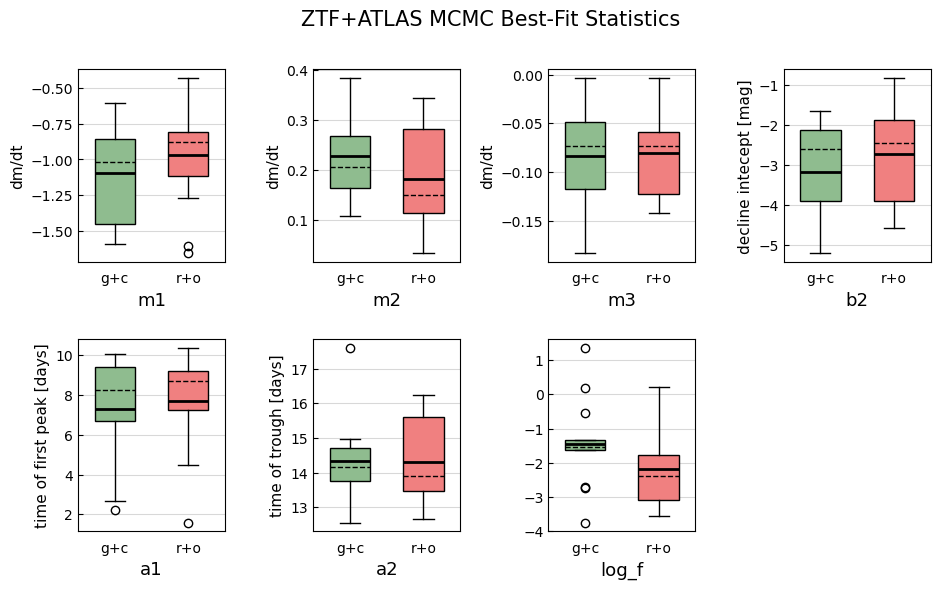

In [19]:
#making box and whisker plots and histograms
xlabels = ['m1', 'm2', 'm3', 'b2', 'a1', 'a2', 'log_f']
ylabels= ['dm/dt','dm/dt','dm/dt','decline intecept [mag]','time of first peak [days]', 'time of trough [days]']
labels = ['g+c','r+o']
boxprops = dict(linewidth=1.0, color='black')
medianprops = dict(linewidth=1.0, color='black', linestyle='--')
meanprops = dict(linewidth=2.0, color='black', linestyle='-')

def box_plot(data, loc=[0,0], label=labels, xlabel=xlabels):
    x1,x2 = loc[0],loc[1]
    bp = axs[x1,x2].boxplot(data, patch_artist=True,labels=label,boxprops=boxprops,medianprops=medianprops,meanprops=meanprops,widths=0.55, showmeans=True, meanline=True)
    colors = ['darkseagreen', 'lightcoral']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)  
    return bp

fig,axs = plt.subplots(2,4,figsize=(11,6))

box_plot([bestfit_df['m1_g'][bestfit_df['m1_g'].notna()],bestfit_df['m1_r'][bestfit_df['m1_r'].notna()]]
         ,loc=[0,0],label=labels,xlabel=xlabels[0])
box_plot([bestfit_df['m2_g'][bestfit_df['m2_g'].notna()],bestfit_df['m2_r'][bestfit_df['m2_r'].notna()]]
         ,loc=[0,1],label=labels,xlabel=xlabels[0])
box_plot([bestfit_df['m3_g'][bestfit_df['m3_g'].notna()],bestfit_df['m3_r'][bestfit_df['m3_r'].notna()]]
         ,loc=[0,2],label=labels,xlabel=xlabels[0])
box_plot([bestfit_df['b2_g'][bestfit_df['b2_g'].notna()],bestfit_df['b2_r'][bestfit_df['b2_r'].notna()]]
         ,loc=[0,3],label=labels,xlabel=xlabels[0])
box_plot([bestfit_df['a1_g'][bestfit_df['a1_g'].notna()],bestfit_df['a1_r'][bestfit_df['a1_r'].notna()]]
         ,loc=[1,0],label=labels,xlabel=xlabels[0])
box_plot([bestfit_df['a2_g'][bestfit_df['a2_g'].notna()],bestfit_df['a2_r'][bestfit_df['a2_r'].notna()]]
         ,loc=[1,1],label=labels,xlabel=xlabels[0])
box_plot([bestfit_df['log_f_g'][bestfit_df['log_f_g'].notna()],bestfit_df['log_f_r'][bestfit_df['log_f_r'].notna()]]
         ,loc=[1,2],label=labels,xlabel=xlabels[0])
axs[1,3].axis("off")

axs[0,0].set_xlabel(xlabels[0],fontsize=13)
axs[0,1].set_xlabel(xlabels[1],fontsize=13)
axs[0,2].set_xlabel(xlabels[2],fontsize=13)
axs[0,3].set_xlabel(xlabels[3],fontsize=13)
axs[1,0].set_xlabel(xlabels[4],fontsize=13)
axs[1,1].set_xlabel(xlabels[5],fontsize=13)
axs[1,2].set_xlabel(xlabels[6],fontsize=13)

axs[0,0].set_ylabel(ylabels[0],fontsize=11)
axs[0,1].set_ylabel(ylabels[1],fontsize=11)
axs[0,2].set_ylabel(ylabels[2],fontsize=11)
axs[0,3].set_ylabel(ylabels[3],fontsize=11)
axs[1,0].set_ylabel(ylabels[4],fontsize=11)
axs[1,1].set_ylabel(ylabels[5],fontsize=11)

axs[0,0].tick_params(axis="y",direction="in")
axs[0,0].tick_params(axis="x",top=False,bottom=False)
axs[0,0].yaxis.grid(color='gray',alpha=0.3, linestyle='-')
axs[0,1].tick_params(axis="y",direction="in")
axs[0,1].tick_params(axis="x",top=False,bottom=False)
axs[0,1].yaxis.grid(color='gray',alpha=0.3, linestyle='-')
axs[0,2].tick_params(axis="y",direction="in")
axs[0,2].tick_params(axis="x",top=False,bottom=False)
axs[0,2].yaxis.grid(color='gray',alpha=0.3, linestyle='-')
axs[0,3].tick_params(axis="y",direction="in")
axs[0,3].tick_params(axis="x",top=False,bottom=False)
axs[0,3].yaxis.grid(color='gray',alpha=0.3, linestyle='-')

axs[1,0].tick_params(axis="y",direction="in")
axs[1,0].tick_params(axis="x",top=False,bottom=False)
axs[1,0].yaxis.grid(color='gray',alpha=0.3, linestyle='-')
axs[1,1].tick_params(axis="y",direction="in")
axs[1,1].tick_params(axis="x",top=False,bottom=False)
axs[1,1].yaxis.grid(color='gray',alpha=0.3, linestyle='-')
axs[1,2].tick_params(axis="y",direction="in")
axs[1,2].tick_params(axis="x",top=False,bottom=False)
axs[1,2].yaxis.grid(color='gray',alpha=0.3, linestyle='-')


fig.subplots_adjust(hspace=0.4,wspace=0.6)
fig.suptitle('ZTF+ATLAS MCMC Best-Fit Statistics', fontsize=15)
plt.savefig(SAVE_DIR+'figures/boxwhisk_params.png',dpi=300)

/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_58638/2846751569.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axs[x1,x2].boxplot(data, patch_artist=True,labels=label,boxprops=boxprops,medianprops=medianprops,meanprops=meanprops,widths=0.55, showmeans=True, meanline=True)
/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_58638/2846751569.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axs[x1,x2].boxplot(data, patch_artist=True,labels=label,boxprops=boxprops,medianprops=medianprops,meanprops=meanprops,widths=0.55, showmeans=True, meanline=True)
/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_58638/2846751569.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been 

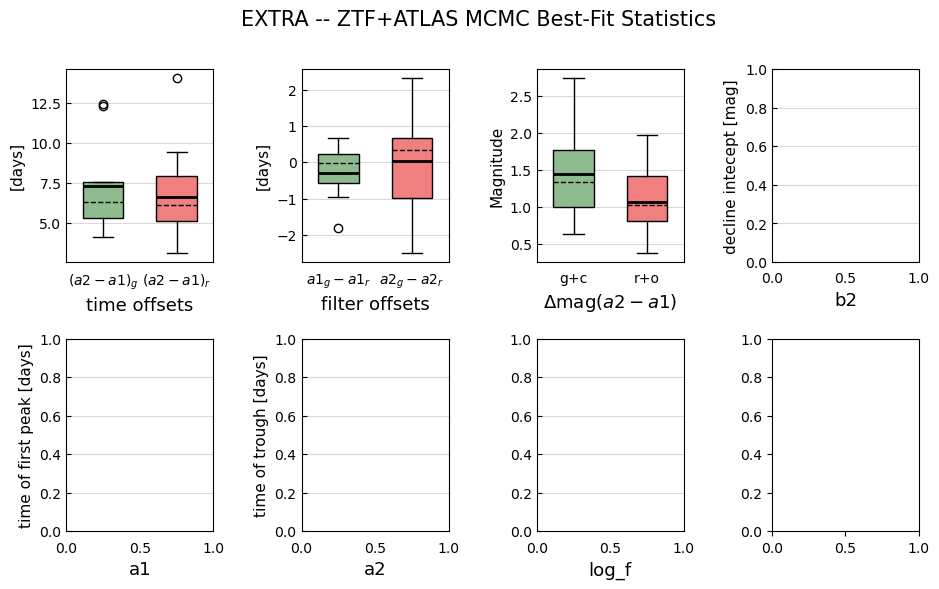

In [20]:
#making box and whisker plots and histograms for extra population stats
xlabels = ['time offsets', 'filter offsets', '$\Delta\mathrm{mag}(a2-a1)$', 'b2', 'a1', 'a2', 'log_f']
ylabels= ['[days]','[days]','Magnitude','decline intecept [mag]','time of first peak [days]', 'time of trough [days]']
labels = ['g+c','r+o']
boxprops = dict(linewidth=1.0, color='black')
medianprops = dict(linewidth=1.0, color='black', linestyle='--')
meanprops = dict(linewidth=2.0, color='black', linestyle='-')

def box_plot(data, loc=[0,0], label=labels, xlabel=xlabels):
    x1,x2 = loc[0],loc[1]
    bp = axs[x1,x2].boxplot(data, patch_artist=True,labels=label,boxprops=boxprops,medianprops=medianprops,meanprops=meanprops,widths=0.55, showmeans=True, meanline=True)
    colors = ['darkseagreen', 'lightcoral']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)  
    return bp

fig,axs = plt.subplots(2,4,figsize=(11,6))

box_plot([bestfit_df['a2g-a1g'][bestfit_df['a2g-a1g'].notna()],bestfit_df['a2r-a1r'][bestfit_df['a2r-a1r'].notna()]]
         ,loc=[0,0],label=['$(a2-a1)_g$','$(a2-a1)_r$'],xlabel=xlabels[0])
box_plot([bestfit_df['a1g-a1r'][bestfit_df['a1g-a1r'].notna()],bestfit_df['a2g-a2r'][bestfit_df['a2g-a2r'].notna()]]
         ,loc=[0,1],label=['$a1_g-a1_r$','$a2_g-a2_r$'],xlabel=xlabels[0])
box_plot([bestfit_df['mag_a2g-a1g'][bestfit_df['mag_a2g-a1g'].notna()],bestfit_df['mag_a2r-a1r'][bestfit_df['mag_a2r-a1r'].notna()]]
         ,loc=[0,2],label=labels,xlabel=[])
# box_plot([bestfit_df['b2_g'][bestfit_df['b2_g'].notna()],bestfit_df['b2_r'][bestfit_df['b2_r'].notna()]]
#          ,loc=[0,3],label=labels,xlabel=xlabels[0])
# box_plot([bestfit_df['a1_g'][bestfit_df['a1_g'].notna()],bestfit_df['a1_r'][bestfit_df['a1_r'].notna()]]
#          ,loc=[1,0],label=labels,xlabel=xlabels[0])
# box_plot([bestfit_df['a2_g'][bestfit_df['a2_g'].notna()],bestfit_df['a2_r'][bestfit_df['a2_r'].notna()]]
#          ,loc=[1,1],label=labels,xlabel=xlabels[0])
# box_plot([bestfit_df['log_f_g'][bestfit_df['log_f_g'].notna()],bestfit_df['log_f_r'][bestfit_df['log_f_r'].notna()]]
#          ,loc=[1,2],label=labels,xlabel=xlabels[0])
# axs[1,3].axis("off")

axs[0,0].set_xlabel(xlabels[0],fontsize=13)
axs[0,1].set_xlabel(xlabels[1],fontsize=13)
axs[0,2].set_xlabel(xlabels[2],fontsize=13)
axs[0,3].set_xlabel(xlabels[3],fontsize=13)
axs[1,0].set_xlabel(xlabels[4],fontsize=13)
axs[1,1].set_xlabel(xlabels[5],fontsize=13)
axs[1,2].set_xlabel(xlabels[6],fontsize=13)

axs[0,0].set_ylabel(ylabels[0],fontsize=11)
axs[0,1].set_ylabel(ylabels[1],fontsize=11)
axs[0,2].set_ylabel(ylabels[2],fontsize=11)
axs[0,3].set_ylabel(ylabels[3],fontsize=11)
axs[1,0].set_ylabel(ylabels[4],fontsize=11)
axs[1,1].set_ylabel(ylabels[5],fontsize=11)

axs[0,0].tick_params(axis="y",direction="in")
axs[0,0].tick_params(axis="x",top=False,bottom=False)
axs[0,0].yaxis.grid(color='gray',alpha=0.3, linestyle='-')
axs[0,1].tick_params(axis="y",direction="in")
axs[0,1].tick_params(axis="x",top=False,bottom=False)
axs[0,1].yaxis.grid(color='gray',alpha=0.3, linestyle='-')
axs[0,2].tick_params(axis="y",direction="in")
axs[0,2].tick_params(axis="x",top=False,bottom=False)
axs[0,2].yaxis.grid(color='gray',alpha=0.3, linestyle='-')
axs[0,3].tick_params(axis="y",direction="in")
axs[0,3].tick_params(axis="x",top=False,bottom=False)
axs[0,3].yaxis.grid(color='gray',alpha=0.3, linestyle='-')

axs[1,0].tick_params(axis="y",direction="in")
axs[1,0].tick_params(axis="x",top=False,bottom=False)
axs[1,0].yaxis.grid(color='gray',alpha=0.3, linestyle='-')
axs[1,1].tick_params(axis="y",direction="in")
axs[1,1].tick_params(axis="x",top=False,bottom=False)
axs[1,1].yaxis.grid(color='gray',alpha=0.3, linestyle='-')
axs[1,2].tick_params(axis="y",direction="in")
axs[1,2].tick_params(axis="x",top=False,bottom=False)
axs[1,2].yaxis.grid(color='gray',alpha=0.3, linestyle='-')


fig.subplots_adjust(hspace=0.4,wspace=0.6)
fig.suptitle('EXTRA -- ZTF+ATLAS MCMC Best-Fit Statistics', fontsize=15)
plt.savefig(SAVE_DIR+'figures/boxwhisk_extra_params.png',dpi=300)

/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_58638/643167910.py:36: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mean_a1_g = float(stats_df[stats_df['filter']=='g'].loc[stats_df['param']=='a1']['mean'])
/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_58638/643167910.py:38: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mean_a2_g = float(stats_df[stats_df['filter']=='g'].loc[stats_df['param']=='a2']['mean'])


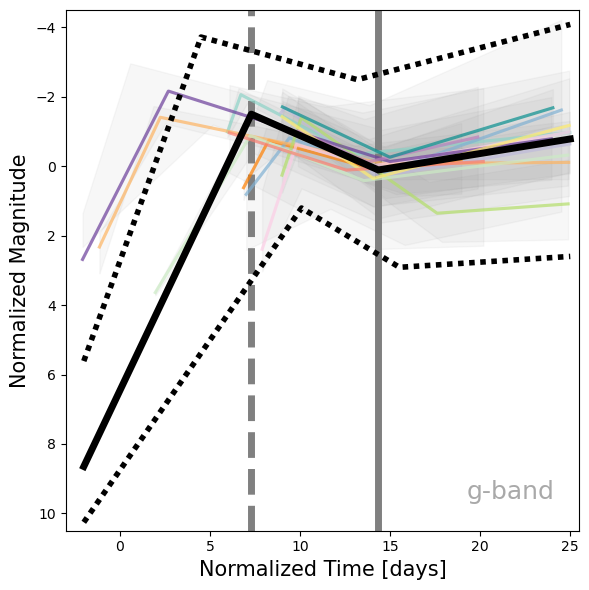

In [21]:
# PLOTTING THE MEAN FIT OVER THE BESTFITS
mean_x = np.arange(-2,25,0.001)

a1s,a2s = [],[]
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111)
for i,df in enumerate(df_sub_ls):
    df_str =  df_str_list[i]
    g_df = df[(df['filter']=='ZTF_g') | (df['filter']=='c')]
    x_plt = np.arange(min(g_df['norm_t']),max(g_df['norm_t']),0.01)

    best = np.array(all_fits_g[i]).T[0] #bestfit values
    lower_bound = np.array(all_fits_g[i]).T[0] - np.array(all_fits_g[i]).T[1] #50th ptile - diff_16ptile
    upper_bound = np.array(all_fits_g[i]).T[0] + np.array(all_fits_g[i]).T[2] #50th ptile + diff_84ptile
    a1s.append(best[-3])
    a2s.append(best[-2])
    
    #plotting mcmc results
    plt.plot(x_plt, np.array([model(best, v, r1=r1_bool_dict['g'][df_str]) for v in x_plt]), c=colors[i], label=plot_names[i], alpha=0.7, linewidth=2.25)# linestyle=ls[i])
    lower_curve = np.array([model(lower_bound, v, r1=r1_bool_dict['g'][df_str]) for v in x_plt])
    upper_curve = np.array([model(upper_bound, v, r1=r1_bool_dict['g'][df_str]) for v in x_plt])
    plt.fill_between(x_plt, lower_curve, upper_curve, color='gray', alpha=0.06)
    
    # #plotting ztf/atlas data
    x,y,yerr = np.array(g_df['norm_t']),np.array(g_df['norm_m']),np.array(g_df['mag_err_all'])
    # plt.errorbar(x, y, yerr, linestyle='', marker='.', color='black', alpha=0.04, label='data', markersize=15) #ztf errors

#overall mean best fit
mean_fit_g = stats_df[stats_df['filter']=='g']['mean']
lower_mean =  np.array([model(stats_df[stats_df['filter']=='g']['mean']-stats_df[stats_df['filter']=='g']['std'],v,r1=True) for v in mean_x])
upper_mean =  np.array([model(stats_df[stats_df['filter']=='g']['mean']+stats_df[stats_df['filter']=='g']['std'],v,r1=True) for v in mean_x])
plt.plot(mean_x, np.array([model(mean_fit_g, v, r1=True) for v in mean_x]),c='black', label='Mean Best Fit', alpha=1.0, linewidth=5.0)
plt.plot(mean_x, lower_mean, color='black', linestyle=(0,(1,1)), alpha=1.0, linewidth=4.0)
plt.plot(mean_x, upper_mean, color='black', linestyle=(0,(1,1)), alpha=1.0, linewidth=4.0)

mean_a1_g = float(stats_df[stats_df['filter']=='g'].loc[stats_df['param']=='a1']['mean'])
# lower_a1_g, upper_a1_g = stats_df[stats_df['filter']=='g'].loc[stats_df['param']=='a1']['mean']-stats_df[stats_df['filter']=='g'].loc[stats_df['param']=='a1']['std'], stats_df[stats_df['filter']=='g'].loc[stats_df['param']=='a1']['mean']+stats_df[stats_df['filter']=='g'].loc[stats_df['param']=='a1']['std']
mean_a2_g = float(stats_df[stats_df['filter']=='g'].loc[stats_df['param']=='a2']['mean'])
# lower_a2_g, upper_a2_g = stats_df[stats_df['filter']=='g'].loc[stats_df['param']=='a2']['mean']-stats_df[stats_df['filter']=='g'].loc[stats_df['param']=='a2']['std'], stats_df[stats_df['filter']=='g'].loc[stats_df['param']=='a2']['mean']+stats_df[stats_df['filter']=='g'].loc[stats_df['param']=='a2']['std']
# plt.axvspan(min_a1, max_a1, alpha=0.03, facecolor='gray', label='a1_range', edgecolor='black', hatch='/', zorder=0)
# plt.axvspan(min_a2, max_a2, alpha=0.03, facecolor='gray', label='a2_range', edgecolor='black', hatch='-', zorder=0)
plt.axvline(mean_a1_g,alpha=1.0, color='gray', linestyle='dashed', linewidth=5, label='Mean a1', zorder=0)
plt.axvline(mean_a2_g,alpha=1.0, color='gray', linestyle='solid', linewidth=5, label='Mean a2', zorder=0)

bbox = dict(facecolor='white', edgecolor='white',alpha=0.85)
plt.annotate('g-band',xy=(0.78,0.06),xycoords='axes fraction',color='darkgray',fontsize=18, bbox=bbox)

plt.xlabel('Normalized Time [days]', fontsize=15)
plt.ylabel('Normalized Magnitude', fontsize=15)
# plt.title('MCMC Mean Best Fit for all g-band SNe', fontsize=15)
plt.ylim(10.5,-4.5)
plt.xlim(-3,25.5)
# ax.legend(handles, labels[0:15], loc='center left', bbox_to_anchor=(1, 0.4),frameon=False, fontsize=12)

plt.tight_layout()
plt.savefig(SAVE_DIR+'/figures/mean_mcmc_fits_g.png')

/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_58638/1553222.py:35: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mean_a1_r = float(stats_df[stats_df['filter']=='r'].loc[stats_df['param']=='a1']['mean'])
/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_58638/1553222.py:37: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mean_a2_r = float(stats_df[stats_df['filter']=='r'].loc[stats_df['param']=='a2']['mean'])


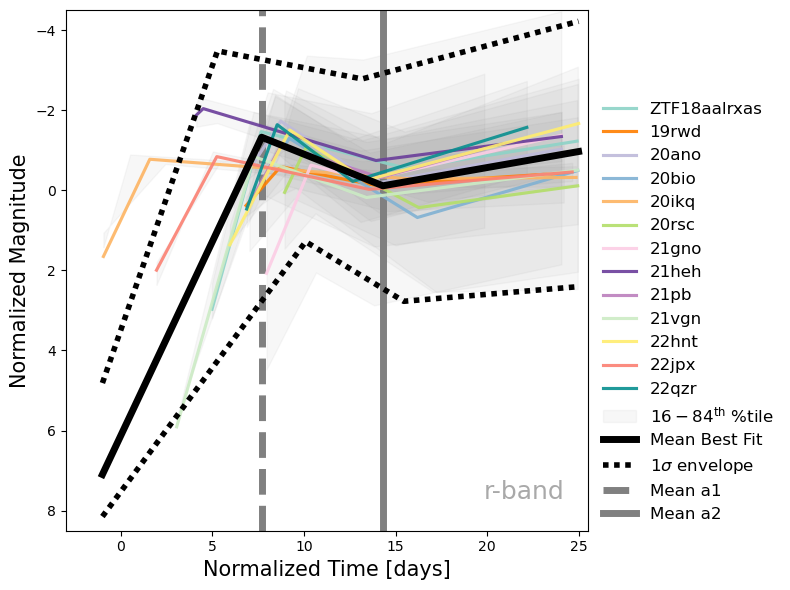

In [22]:
mean_x = np.arange(-1,25,0.01)

a1s,a2s = [],[]
plt.figure(figsize=(8,6))
ax = plt.subplot(111)
for i,df in enumerate(df_sub_ls):
    df_str = df_str_list[i]
    r_df = df[(df['filter']=='ZTF_r') | (df['filter']=='o')]
    x_plt = np.arange(min(r_df['norm_t']),max(r_df['norm_t']),0.01)

    best = np.array(all_fits_r[i]).T[0] #bestfit values
    lower_bound = np.array(all_fits_r[i]).T[0] - np.array(all_fits_r[i]).T[1] #50th ptile - diff_16ptile
    upper_bound = np.array(all_fits_r[i]).T[0] + np.array(all_fits_r[i]).T[2] #50th ptile + diff_84ptile
    a1s.append(best[-3])
    a2s.append(best[-2])
    
    #plotting mcmc results
    plt.plot(x_plt, np.array([model(best, v, r1=r1_bool_dict['r'][df_str]) for v in x_plt]), c=colors[i], label=plot_names[i], alpha=0.9, linewidth=2.25)# linestyle=ls[i])
    lower_curve = np.array([model(lower_bound, v, r1=r1_bool_dict['r'][df_str]) for v in x_plt])
    upper_curve = np.array([model(upper_bound, v, r1=r1_bool_dict['r'][df_str]) for v in x_plt])
    plt.fill_between(x_plt, lower_curve, upper_curve, color='gray', alpha=0.06, label='$16-84^{\mathrm{th}}$ %tile')

    #plotting ztf data
    x,y,yerr = np.array(r_df['norm_t']),np.array(r_df['norm_m']),np.array(r_df['mag_err_all'])
    # plt.errorbar(x, y, yerr, linestyle='', marker='.', color='gray', alpha=0.05, label='data', markersize=15) #ztf errors, 

#overall mean best fit
mean_fit_r = stats_df[stats_df['filter']=='r']['mean']
lower_mean =  np.array([model(stats_df[stats_df['filter']=='r']['mean']-stats_df[stats_df['filter']=='r']['std'],v,r1=True) for v in mean_x])
upper_mean =  np.array([model(stats_df[stats_df['filter']=='r']['mean']+stats_df[stats_df['filter']=='r']['std'],v,r1=True) for v in mean_x])
plt.plot(mean_x, np.array([model(mean_fit_r, v, r1=True) for v in mean_x]),c='black', label='Mean Best Fit', alpha=1.0, linewidth=5.0)
plt.plot(mean_x, lower_mean, color='black', linestyle=(0,(1,1)), alpha=1.0, linewidth=4)
plt.plot(mean_x, upper_mean, color='black', linestyle=(0,(1,1)), alpha=1.0, linewidth=4, label='$1\sigma$ envelope')

mean_a1_r = float(stats_df[stats_df['filter']=='r'].loc[stats_df['param']=='a1']['mean'])
# lower_a1_g, upper_a1_g = stats_df[stats_df['filter']=='g'].loc[stats_df['param']=='a1']['mean']-stats_df[stats_df['filter']=='g'].loc[stats_df['param']=='a1']['std'], stats_df[stats_df['filter']=='g'].loc[stats_df['param']=='a1']['mean']+stats_df[stats_df['filter']=='g'].loc[stats_df['param']=='a1']['std']
mean_a2_r = float(stats_df[stats_df['filter']=='r'].loc[stats_df['param']=='a2']['mean'])
# lower_a2_g, upper_a2_g = stats_df[stats_df['filter']=='g'].loc[stats_df['param']=='a2']['mean']-stats_df[stats_df['filter']=='g'].loc[stats_df['param']=='a2']['std'], stats_df[stats_df['filter']=='g'].loc[stats_df['param']=='a2']['mean']+stats_df[stats_df['filter']=='g'].loc[stats_df['param']=='a2']['std']
# plt.axvspan(min_a1, max_a1, alpha=0.03, facecolor='gray', label='a1_range', edgecolor='black', hatch='/', zorder=0)
# plt.axvspan(min_a2, max_a2, alpha=0.03, facecolor='gray', label='a2_range', edgecolor='black', hatch='-', zorder=0)
plt.axvline(mean_a1_r,alpha=1.0, color='gray', linestyle='dashed', linewidth=5, label='Mean a1', zorder=0)
plt.axvline(mean_a2_r,alpha=1.0, color='gray', linestyle='solid', linewidth=5, label='Mean a2', zorder=0)

bbox = dict(facecolor='white', edgecolor='white',alpha=0.85)
plt.annotate('r-band',xy=(0.8,0.06),xycoords='axes fraction',color='darkgray',fontsize=18, bbox=bbox)

plt.xlabel('Normalized Time [days]', fontsize=15)
plt.ylabel('Normalized Magnitude', fontsize=15)
# plt.title('MCMC Mean Best Fit for all r-band SNe', fontsize=15)
plt.ylim(8.5,-4.5)
plt.xlim(-3,25.5)
handles, labels = ax.get_legend_handles_labels()
h, l = handles[:26:2], labels[:26:2]
h2, l2 = handles[25:], labels[25:]
hand, lab = h+h2, l+l2
ax.legend(hand, lab, loc='center left', bbox_to_anchor=(1, 0.42),frameon=False, fontsize=12)
plt.tight_layout()
plt.savefig(SAVE_DIR+'/figures/mean_mcmc_fits_r.png')

In [23]:
# plot_names = ['ZTF18aalrxas', '19rwd', '20ano','20bio','20ikq','20rsc','21gno','21heh','21vgn','22hnt','22jpx','22qzr']

# fig, axs = plt.subplots(4,3, figsize=(9,12))
# locs = [[0,0],[0,1],[0,2],[1,0],[1,1],[1,2],[2,0],[2,1],[2,2],[3,0],[3,1],[3,2]]

# for i,df in enumerate(df_sub_ls):
#     df_str = df_str_list[i]
#     g_df = df[(df['filter']=='ZTF_g') | (df['filter']=='c')]
#     x_plt = np.arange(min(g_df['norm_t']),max(g_df['norm_t']),0.01)

#     best = np.array(all_fits_g[i]).T[0] #bestfit values
#     lower_bound = np.array(all_fits_g[i]).T[0] - np.array(all_fits_g[i]).T[1] #50th ptile - diff_16ptile
#     upper_bound = np.array(all_fits_g[i]).T[0] + np.array(all_fits_g[i]).T[2] #50th ptile + diff_84ptile
#     a1s.append(best[-3])
#     a2s.append(best[-2])
    
#     #plotting mcmc results
#     axs[locs[i][0],locs[i][1]].plot(x_plt, np.array([model(best, v, r1=r1_bool_dict['g'][df_str]) for v in x_plt]), c=colors[i], label=plot_names[i], linewidth=2.25)# linestyle=ls[i])
#     axs[locs[i][0],locs[i][1]].axvline(float(bestfit_df[bestfit_df['SN_ID']==df_str]['a1_g']), color='gray', linestyle='--',zorder=1, linewidth=2, alpha=0.8, label='a1')
#     axs[locs[i][0],locs[i][1]].axvline(float(bestfit_df[bestfit_df['SN_ID']==df_str]['a2_g']), color='gray', zorder=1, linewidth=2, alpha=0.8, label='a2')

#     #plotting ztf data
#     x,y,yerr = np.array(g_df['norm_t']),np.array(g_df['norm_m']),np.array(g_df['mag_err_all'])
#     axs[locs[i][0],locs[i][1]].errorbar(x, y, yerr, linestyle='', marker='.', color='gray', alpha=0.1, markersize=15, zorder=0, label='g+c') #ztf errors,

#     bbox = dict(facecolor='white', edgecolor='white',alpha=0.85)
#     axs[locs[i][0],locs[i][1]].annotate(plot_names[i],xy=(0.08,0.12),xycoords='axes fraction',color=colors[i],fontsize=14, bbox=bbox)

#     # axs[locs[i][0],locs[i][1]].set_xlabel('Normalized Time [days]')
#     # axs[locs[i][0],locs[i][1]].set_ylabel('Normalized Magnitude')
#     axs[locs[i][0],locs[i][1]].set_ylim(max(y)+2, min(y)-1)
#     axs[locs[i][0],locs[i][1]].xaxis.set_minor_locator(AutoMinorLocator())
#     axs[locs[i][0],locs[i][1]].yaxis.set_minor_locator(AutoMinorLocator())
#     axs[locs[i][0],locs[i][1]].tick_params(which="both",top=False, labeltop=False, bottom=True, labelbottom=True, left=True, right=False, direction="in",zorder=0)

# axs[3,0].set_xlabel('Normalized Time [days]')
# axs[3,1].set_xlabel('Normalized Time [days]')
# axs[3,2].set_xlabel('Normalized Time [days]')

# axs[0,0].set_ylabel('Normalized Magnitude')
# axs[1,0].set_ylabel('Normalized Magnitude')
# axs[2,0].set_ylabel('Normalized Magnitude')
# axs[3,0].set_ylabel('Normalized Magnitude')


# handles, labels = axs[3,0].get_legend_handles_labels()
# fig.legend(handles[1:], labels[1:], loc='center left', bbox_to_anchor=(.835, 0.095),fontsize='x-large',markerscale=1.5,
#                 frameon=True,fancybox=False,framealpha=1.0,edgecolor='darkgray')
# plt.tight_layout()
# plt.savefig(SAVE_DIR+'/figures/individ_mcmc_g_fits_subplot.png', dpi=300)

In [24]:
# fig, axs = plt.subplots(4,3, figsize=(9,12))
# locs = [[0,0],[0,1],[0,2],[1,0],[1,1],[1,2],[2,0],[2,1],[2,2],[3,0],[3,1],[3,2]]

# for i,df in enumerate(df_sub_ls):
#     df_str = df_str_list[i]
#     r_df = df[(df['filter']=='ZTF_r') | (df['filter']=='o')]
#     x_plt = np.arange(min(r_df['norm_t']),max(r_df['norm_t']),0.01)

#     best = np.array(all_fits_r[i]).T[0] #bestfit values
#     lower_bound = np.array(all_fits_r[i]).T[0] - np.array(all_fits_r[i]).T[1] #50th ptile - diff_16ptile
#     upper_bound = np.array(all_fits_r[i]).T[0] + np.array(all_fits_r[i]).T[2] #50th ptile + diff_84ptile
#     a1s.append(best[-3])
#     a2s.append(best[-2])
    
#     #plotting mcmc results
#     axs[locs[i][0],locs[i][1]].plot(x_plt, np.array([model(best, v, r1=r1_bool_dict['r'][df_str]) for v in x_plt]), c=colors[i], label=plot_names[i], linewidth=2.25)# linestyle=ls[i])
#     axs[locs[i][0],locs[i][1]].axvline(float(bestfit_df[bestfit_df['SN_ID']==df_str]['a1_r']), color='gray', linestyle='--',zorder=1, linewidth=2, alpha=0.8, label='a1')
#     axs[locs[i][0],locs[i][1]].axvline(float(bestfit_df[bestfit_df['SN_ID']==df_str]['a2_r']), color='gray', zorder=1, linewidth=2, alpha=0.8, label='a2')

#     #plotting ztf data
#     x,y,yerr = np.array(r_df['norm_t']),np.array(r_df['norm_m']),np.array(r_df['mag_err_all'])
#     axs[locs[i][0],locs[i][1]].errorbar(x, y, yerr, linestyle='', marker='.', color='gray', alpha=0.1, markersize=15, zorder=0, label='r+o') #ztf errors,

#     bbox = dict(facecolor='white', edgecolor='white',alpha=0.85)
#     axs[locs[i][0],locs[i][1]].annotate(plot_names[i],xy=(0.08,0.12),xycoords='axes fraction',color=colors[i],fontsize=14, bbox=bbox)

#     # axs[locs[i][0],locs[i][1]].set_xlabel('Normalized Time [days]')
#     # axs[locs[i][0],locs[i][1]].set_ylabel('Normalized Magnitude')
#     axs[locs[i][0],locs[i][1]].set_ylim(max(y)+2, min(y)-1)
#     axs[locs[i][0],locs[i][1]].xaxis.set_minor_locator(AutoMinorLocator())
#     axs[locs[i][0],locs[i][1]].yaxis.set_minor_locator(AutoMinorLocator())
#     axs[locs[i][0],locs[i][1]].tick_params(which="both",top=False, labeltop=False, bottom=True, labelbottom=True, left=True, right=False, direction="in",zorder=0)


# axs[3,0].set_xlabel('Normalized Time [days]')
# axs[3,1].set_xlabel('Normalized Time [days]')
# axs[3,2].set_xlabel('Normalized Time [days]')

# axs[0,0].set_ylabel('Normalized Magnitude')
# axs[1,0].set_ylabel('Normalized Magnitude')
# axs[2,0].set_ylabel('Normalized Magnitude')
# axs[3,0].set_ylabel('Normalized Magnitude')


# handles, labels = axs[3,0].get_legend_handles_labels()
# fig.legend(handles[1:], labels[1:], loc='center left', bbox_to_anchor=(.835, 0.095),fontsize='x-large',markerscale=1.5,
#                 frameon=True,fancybox=False,framealpha=1.0,edgecolor='darkgray')
# plt.tight_layout()
# plt.savefig(SAVE_DIR+'/figures/individ_mcmc_r_fits_subplot.png', dpi=300)

/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_58638/4207064982.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  axs[glocs[i][0],glocs[i][1]].axvline(float(bestfit_df[bestfit_df['SN_ID']==df_str]['a1_g']), color='gray', linestyle='--',zorder=1, linewidth=2, alpha=0.8, label='a1')
/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_58638/4207064982.py:28: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  axs[glocs[i][0],glocs[i][1]].axvline(float(bestfit_df[bestfit_df['SN_ID']==df_str]['a2_g']), color='gray', zorder=1, linewidth=2, alpha=0.8, label='a2')
/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_58638/4207064982.py:49: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) inste

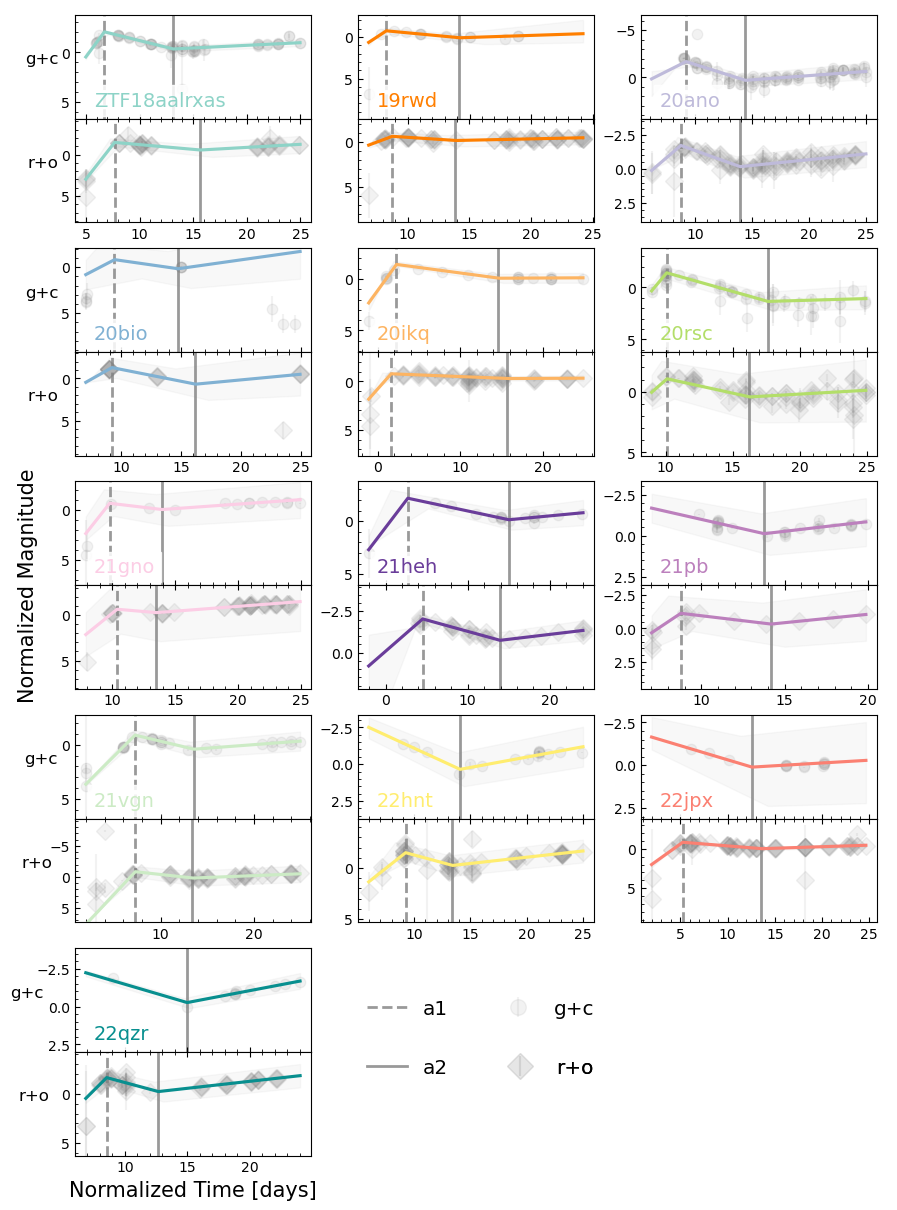

In [25]:
%matplotlib inline
# COMBIINING THE SUBPOTS TO COMPARE B/W G AND R RESULTS

gridspec = dict(hspace=0.0, wspace=0.2, height_ratios=[1,1,0.25,1,1,0.25,1,1,0.25,1,1,0.25,1,1])
fig, axs = plt.subplots(14,3, figsize=(9,12), sharex=False, gridspec_kw=gridspec)
glocs = [[0,0],[0,1],[0,2],[3,0],[3,1],[3,2],[6,0],[6,1],[6,2],[9,0],[9,1],[9,2],[12,0],[12,1]]
rlocs = [[1,0],[1,1],[1,2],[4,0],[4,1],[4,2],[7,0],[7,1],[7,2],[10,0],[10,1],[10,2],[13,0],[13,1]]
elocs = [[2,0],[2,1],[2,2],[5,0],[5,1],[5,2],[8,0],[8,1],[8,2],[11,0],[11,1]]

for i,df in enumerate(df_sub_ls):
    df_str = df_str_list[i]
    g_df = df[(df['filter']=='ZTF_g') | (df['filter']=='c')]
    r_df = df[(df['filter']=='ZTF_r') | (df['filter']=='o')]

    x_plt = np.arange(min(list(g_df['norm_t'])+list(r_df['norm_t'])),max(list(g_df['norm_t'])+list(r_df['norm_t'])),0.01)

    ################## g band
    best = np.array(all_fits_g[i]).T[0] #bestfit values
    lower_bound = np.array(all_fits_g[i]).T[0] - np.array(all_fits_g[i]).T[1] #50th ptile - diff_16ptile
    upper_bound = np.array(all_fits_g[i]).T[0] + np.array(all_fits_g[i]).T[2] #50th ptile + diff_84ptile
    
    #plotting mcmc results
    axs[glocs[i][0],glocs[i][1]].plot(x_plt, np.array([model(best, v, r1=r1_bool_dict['g'][df_str]) for v in x_plt]), c=colors[i], label=plot_names[i], linewidth=2.25)# linestyle=ls[i])
    lower_curve = np.array([model(lower_bound, v, r1=r1_bool_dict['g'][df_str]) for v in x_plt])
    upper_curve = np.array([model(upper_bound, v, r1=r1_bool_dict['g'][df_str]) for v in x_plt])
    axs[glocs[i][0],glocs[i][1]].fill_between(x_plt, lower_curve, upper_curve, color='gray', alpha=0.05, zorder=0)
    axs[glocs[i][0],glocs[i][1]].axvline(float(bestfit_df[bestfit_df['SN_ID']==df_str]['a1_g']), color='gray', linestyle='--',zorder=1, linewidth=2, alpha=0.8, label='a1')
    axs[glocs[i][0],glocs[i][1]].axvline(float(bestfit_df[bestfit_df['SN_ID']==df_str]['a2_g']), color='gray', zorder=1, linewidth=2, alpha=0.8, label='a2')

    #plotting ztf data
    x,y,yerr = np.array(g_df['norm_t']),np.array(g_df['norm_m']),np.array(g_df['mag_err_all'])
    axs[glocs[i][0],glocs[i][1]].errorbar(x, y, yerr, linestyle='', marker='.', color='gray', alpha=0.1, markersize=15, zorder=0, label='g+c') #ztf errors,

    axs[glocs[i][0],glocs[i][1]].set_ylim(max(y)+3, min(y)-2)
    axs[glocs[i][0],glocs[i][1]].xaxis.set_minor_locator(AutoMinorLocator())
    axs[glocs[i][0],glocs[i][1]].yaxis.set_minor_locator(AutoMinorLocator())
    axs[glocs[i][0],glocs[i][1]].tick_params(which="both",top=False, labeltop=False, bottom=True, labelbottom=False, left=True, right=False, direction="in",zorder=0)

    ################## r band
    best_r = np.array(all_fits_r[i]).T[0] #bestfit values
    lower_bound_r = np.array(all_fits_r[i]).T[0] - np.array(all_fits_r[i]).T[1] #50th ptile - diff_16ptile
    upper_bound_r = np.array(all_fits_r[i]).T[0] + np.array(all_fits_r[i]).T[2] #50th ptile + diff_84ptile
    
    #plotting mcmc results
    axs[rlocs[i][0],rlocs[i][1]].plot(x_plt, np.array([model(best_r, v, r1=r1_bool_dict['r'][df_str]) for v in x_plt]), c=colors[i], label=plot_names[i], linewidth=2.25)# linestyle=ls[i])
    lower_curve_r = np.array([model(lower_bound_r, v, r1=r1_bool_dict['r'][df_str]) for v in x_plt])
    upper_curve_r = np.array([model(upper_bound_r, v, r1=r1_bool_dict['r'][df_str]) for v in x_plt])
    axs[rlocs[i][0],rlocs[i][1]].fill_between(x_plt, lower_curve_r, upper_curve_r, color='gray', alpha=0.05, zorder=0)
    axs[rlocs[i][0],rlocs[i][1]].axvline(bestfit_df[bestfit_df['SN_ID']==df_str]['a1_r'].iloc[0], color='gray', linestyle='--',zorder=1, linewidth=2, alpha=0.8, label='a1')
    axs[rlocs[i][0],rlocs[i][1]].axvline(bestfit_df[bestfit_df['SN_ID']==df_str]['a2_r'].iloc[0], color='gray', zorder=1, linewidth=2, alpha=0.8, label='a2')

    #plotting ztf data
    xr,yr,yerrr = np.array(r_df['norm_t']),np.array(r_df['norm_m']),np.array(r_df['mag_err_all'])
    axs[rlocs[i][0],rlocs[i][1]].errorbar(xr, yr, yerrr, linestyle='', marker='D', color='gray', alpha=0.1, markersize=9, zorder=0, label='r+o') #ztf errors,

    axs[rlocs[i][0],rlocs[i][1]].set_ylim(max(yr)+3, min(yr)-2)
    axs[rlocs[i][0],rlocs[i][1]].xaxis.set_minor_locator(AutoMinorLocator())
    axs[rlocs[i][0],rlocs[i][1]].yaxis.set_minor_locator(AutoMinorLocator())
    axs[rlocs[i][0],rlocs[i][1]].tick_params(which="both",top=True, labeltop=False, bottom=True, labelbottom=True, left=True, right=False, direction="in",zorder=0)

    ########## labels
    bbox = dict(facecolor='white', edgecolor='white',alpha=0.85)
    axs[glocs[i][0],glocs[i][1]].annotate(plot_names[i],xy=(0.08,0.12),xycoords='axes fraction',color=colors[i],fontsize=14, bbox=bbox)

for i,e in enumerate(elocs):
    axs[e[0],e[1]].set_visible(False)

axs[12,1].axis("off")
axs[12,2].axis("off")
axs[13,1].axis("off")
axs[13,2].axis("off")
axs[11,1].axis("off")
axs[11,2].axis("off")

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
axs[13,0].set_xlabel("Normalized Time [days]", fontsize=15)
plt.ylabel("Normalized Magnitude", fontsize=15)
axs[0,0].set_ylabel('g+c', rotation=0, labelpad=14, fontsize=12)
axs[1,0].set_ylabel("r+o", rotation=0, labelpad=13, fontsize=12)
axs[3,0].set_ylabel('g+c', rotation=0, labelpad=14, fontsize=12)
axs[4,0].set_ylabel("r+o", rotation=0, labelpad=13, fontsize=12)
axs[9,0].set_ylabel('g+c', rotation=0, labelpad=15, fontsize=12)
axs[10,0].set_ylabel("r+o", rotation=0, labelpad=9, fontsize=12)
axs[12,0].set_ylabel('g+c', rotation=0, labelpad=7, fontsize=12)
axs[13,0].set_ylabel("r+o", rotation=0, labelpad=20, fontsize=12)

handles, labels = axs[12,0].get_legend_handles_labels()
fig.legend(handles[1:], labels[1:], loc='center left', bbox_to_anchor=(0.385, 0.13),fontsize='x-large',markerscale=1.5,
                frameon=False,fancybox=False,ncols=2,labelspacing=2.0,columnspacing=2.5)

h1, l1 = axs[10,2].get_legend_handles_labels()
h, l = h1[3:], l1[3:]
leg1 = axs[10,2].legend(h, l, loc='center left', bbox_to_anchor=(-0.675, -1.4),fontsize='x-large',markerscale=1.5,
                frameon=False,fancybox=False,)
axs[10,2].add_artist(leg1)

plt.tight_layout()
plt.savefig(SAVE_DIR+'/figures/individ_mcmc_fits_subplot_both_bands.png', dpi=300)

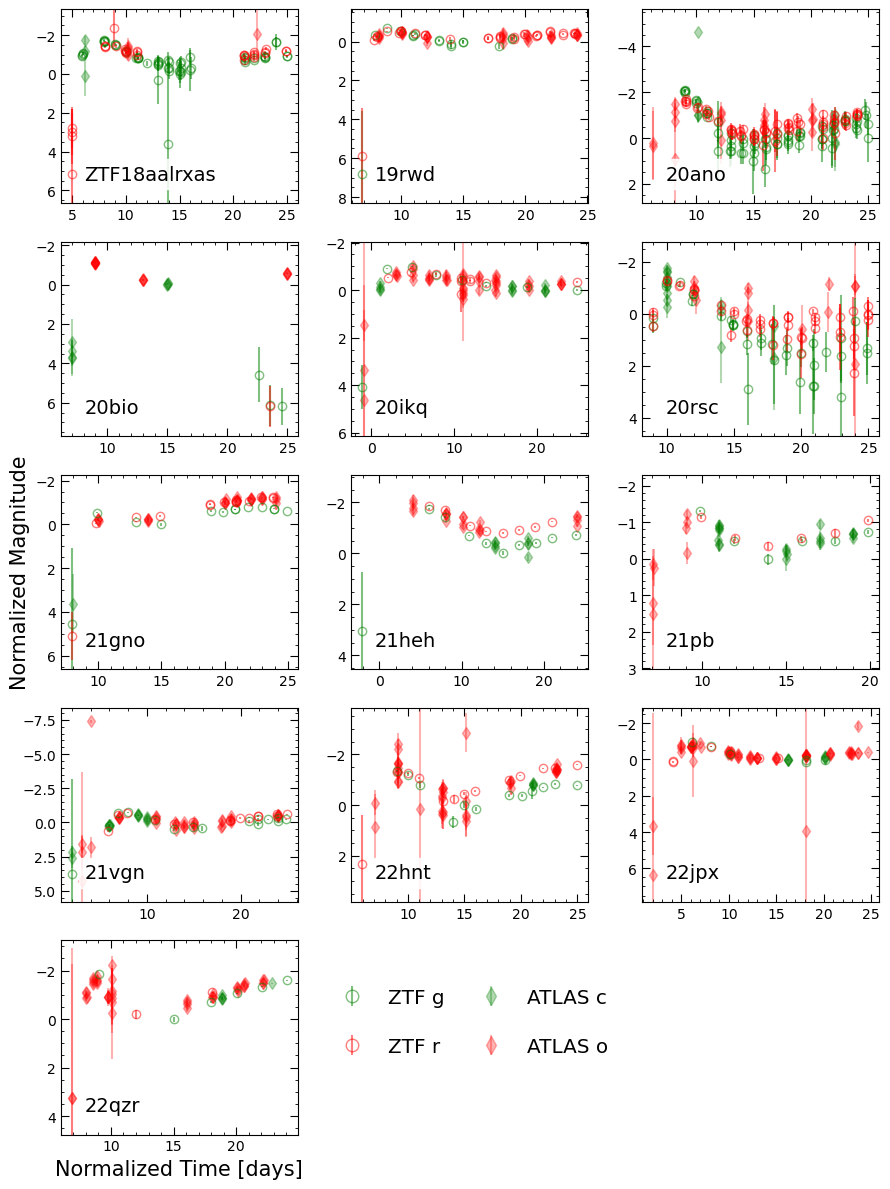

In [26]:
fig, axs = plt.subplots(5,3, figsize=(9,12))
locs = [[0,0],[0,1],[0,2],[1,0],[1,1],[1,2],[2,0],[2,1],[2,2],[3,0],[3,1],[3,2],[4,0]]

for i,df in enumerate(df_sub_ls):
    axs[locs[i][0],locs[i][1]].errorbar(df[df['filter']=='ZTF_g']['norm_t'], df[df['filter']=='ZTF_g']['norm_m'],df[df['filter']=='ZTF_g']['mag_err_all'],
                 markeredgecolor='green',markerfacecolor='none',ecolor='green',label='ZTF g',alpha=0.5,linestyle='',marker='o')
    axs[locs[i][0],locs[i][1]].errorbar(df[df['filter']=='ZTF_r']['norm_t'], df[df['filter']=='ZTF_r']['norm_m'],df[df['filter']=='ZTF_r']['mag_err_all'],
                 markeredgecolor='red',markerfacecolor='none',ecolor='red',label='ZTF r',alpha=0.5,linestyle='',marker='o')
    axs[locs[i][0],locs[i][1]].errorbar(df[df['filter']=='c']['norm_t'], df[df['filter']=='c']['norm_m'],df[df['filter']=='c']['mag_err_all'],
                 color='green', marker='d',label='ATLAS c',alpha=0.3,linestyle='',zorder=0)
    axs[locs[i][0],locs[i][1]].errorbar(df[df['filter']=='o']['norm_t'], df[df['filter']=='o']['norm_m'],df[df['filter']=='o']['mag_err_all'],
                 color='red', marker='d', label='ATLAS o',alpha=0.3,linestyle='',zorder=0)
    
    y_mins = [df[df['filter']=='ZTF_g']['norm_m'].min(), df[df['filter']=='ZTF_r']['norm_m'].min(), df[df['filter']=='c']['norm_m'].min(), df[df['filter']=='o']['norm_m'].min()]
    y_maxs = [df[df['filter']=='ZTF_g']['norm_m'].max(), df[df['filter']=='ZTF_r']['norm_m'].max(), df[df['filter']=='c']['norm_m'].max(), df[df['filter']=='o']['norm_m'].max()]
    
    axs[locs[i][0],locs[i][1]].set_ylim(max(y_maxs)+1.5, min(y_mins)-1)
    axs[locs[i][0],locs[i][1]].xaxis.set_minor_locator(AutoMinorLocator())
    axs[locs[i][0],locs[i][1]].yaxis.set_minor_locator(AutoMinorLocator())
    axs[locs[i][0],locs[i][1]].tick_params(which="both", top=True, labeltop=False, bottom=True, labelbottom=True, left=True, right=True, direction="in")
    axs[locs[i][0],locs[i][1]].xaxis.set_tick_params(length=6)
    axs[locs[i][0],locs[i][1]].yaxis.set_tick_params(length=6)
    
    bbox = dict(facecolor='white', edgecolor='white',alpha=0.85)
    axs[locs[i][0],locs[i][1]].annotate(plot_names[i],xy=(0.1,0.12),xycoords='axes fraction',color='k',fontsize=14,bbox=bbox)

axs[4,1].axis("off")
axs[4,2].axis("off")

# axs[4,0].set_xlabel('Normalized Time [days]')
axs[4,0].set_xlabel('Normalized Time [days]', fontsize=15)
# axs[3,2].set_xlabel('Normalized Time [days]')

axs[2,0].set_ylabel('Normalized Magnitude', fontsize=15)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines[0:4], labels[0:4], loc='lower center', bbox_to_anchor=(0.528, 0.1), ncol=2, fontsize='x-large',markerscale=1.5,
                frameon=False,fancybox=False,framealpha=1.0,edgecolor='darkgray', labelspacing=1.5, columnspacing=1.3)
fig.tight_layout()
plt.savefig(SAVE_DIR+'/figures/individ_fp_lcs_subplot.png',dpi=300)

In [397]:
#############################
#  making absolute mag plots
#############################

#### TODO: read in cleaned_binned_cut.csv files instead of ztf_atlas_df.csv fiels ####

In [596]:
xlims_jd_dict = {'snztf18':[24+2.4582e6, 65+2.4582e6],
               'sn19rwd':[760+2.458e6, 810+2.458e6],
               'sn20bio':[2458873.5, 2458920.5],
               'sn20ano':[868+2.458e6, 915+2.458e6],
               'sn20ikq':[-35+2.459e6, 15+2.459e6],
               'sn20rsc':[75+2.459e6, 107+2.459e6],
               'sn21gno':[290+2.459e6, 330+2.459e6],
               'sn21heh':[2459290.5, 2459340.5],
               'sn21vgn':[2459430.5, 2459480.5],
               'sn22hnt':[2459680.5, 2459730.5],
               'sn22jpx':[2459705.5, 2459740.5],
               'sn22qzr':[795+2.459e6, 875+2.459e6],
               'sn21pb':[18+2.4592e6, 60+2.4592e6],
                }

xlims_mjd_dict = {}
for k in xlims_jd_dict.keys():
    lims = [val-2400000.5 for val in xlims_jd_dict[k]]
    xlims_mjd_dict.update({k:lims})

xlims_mjd_dict

{'snztf18': [58223.5, 58264.5],
 'sn19rwd': [58759.5, 58809.5],
 'sn20bio': [58873.0, 58920.0],
 'sn20ano': [58867.5, 58914.5],
 'sn20ikq': [58964.5, 59014.5],
 'sn20rsc': [59074.5, 59106.5],
 'sn21gno': [59289.5, 59329.5],
 'sn21heh': [59290.0, 59340.0],
 'sn21vgn': [59430.0, 59480.0],
 'sn22hnt': [59680.0, 59730.0],
 'sn22jpx': [59705.0, 59740.0],
 'sn22qzr': [59794.5, 59874.5],
 'sn21pb': [59217.5, 59259.5]}

In [655]:
# read in the CLEANED AND AVERAGED data 
snztf18_full = pd.read_csv('./cleaning/outputs/snztf18_cleaned_binned_cut.csv')
sn19rwd_full = pd.read_csv('./cleaning/outputs/sn19rwd_cleaned_binned_cut.csv')
sn20bio_full = pd.read_csv('./cleaning/outputs/sn20bio_cleaned_binned_cut.csv')
sn21gno_full = pd.read_csv('./cleaning/outputs/sn21gno_cleaned_binned_cut.csv')
sn21heh_full = pd.read_csv('./cleaning/outputs/sn21heh_cleaned_binned_cut.csv')
sn21vgn_full = pd.read_csv('./cleaning/outputs/sn21vgn_cleaned_binned_cut.csv')
sn22hnt_full = pd.read_csv('./cleaning/outputs/sn22hnt_cleaned_binned_cut.csv')
sn22jpx_full = pd.read_csv('./cleaning/outputs/sn22jpx_cleaned_binned_cut.csv')
sn22qzr_full = pd.read_csv('./cleaning/outputs/sn22qzr_cleaned_binned_cut.csv')
# # added later
sn20ano_full = pd.read_csv('./cleaning/outputs/sn20ano_cleaned_binned_cut.csv',)
sn20ikq_full = pd.read_csv('./cleaning/outputs/sn20ikq_cleaned_binned_cut.csv',)
sn20rsc_full = pd.read_csv('./cleaning/outputs/sn20rsc_cleaned_binned_cut.csv',)
sn21pb_full =  pd.read_csv('./cleaning/outputs/sn21pb_cleaned_binned_cut.csv',)

df_list_full = [snztf18_full,sn19rwd_full,sn20ano_full,sn20bio_full,sn20ikq_full,sn20rsc_full,sn21gno_full,sn21heh_full,
           sn21pb_full, sn21vgn_full,sn22hnt_full,sn22jpx_full,sn22qzr_full]

def slice_df(df,mjd_lims=[0,0]):
    low = mjd_lims[0]
    high = mjd_lims[1]
    return df[(low<=df['mjd']) & (df['mjd']<=high) & (df['mag']>0)].reset_index(drop=True)

snztf18_cut = slice_df(snztf18_full,xlims_mjd_dict['snztf18'])
sn19rwd_cut = slice_df(sn19rwd_full,xlims_mjd_dict['sn19rwd'])
sn20ano_cut = slice_df(sn20ano_full,xlims_mjd_dict['sn20ano'])
sn20bio_cut = slice_df(sn20bio_full,xlims_mjd_dict['sn20bio'])
sn20ikq_cut = slice_df(sn20ikq_full,xlims_mjd_dict['sn20ikq'])
sn20rsc_cut = slice_df(sn20rsc_full,xlims_mjd_dict['sn20rsc'])
sn21gno_cut = slice_df(sn21gno_full,xlims_mjd_dict['sn21gno'])
sn21heh_cut = slice_df(sn21heh_full,xlims_mjd_dict['sn21heh'])
sn21pb_cut = slice_df(sn21pb_full, xlims_mjd_dict['sn21pb'])
sn21vgn_cut = slice_df(sn21vgn_full,xlims_mjd_dict['sn21vgn'])
sn22hnt_cut = slice_df(sn22hnt_full,xlims_mjd_dict['sn22hnt'])
sn22jpx_cut = slice_df(sn22jpx_full,xlims_mjd_dict['sn22jpx'])
sn22qzr_cut = slice_df(sn22qzr_full,xlims_mjd_dict['sn22qzr'])

df_cut_list = [snztf18_cut,sn19rwd_cut,sn20ano_cut,sn20bio_cut,sn20ikq_cut,sn20rsc_cut,sn21gno_cut,
               sn21heh_cut,sn21pb_cut,sn21vgn_cut,sn22hnt_cut,sn22jpx_cut,sn22qzr_cut]

def norm_to_a2_mjd(df_cut, sn_id):
    mjd_at_a2 = mag_conversion_df.loc[mag_conversion_df['sn']==sn_id,'mjd_at_a2'].iloc[0]
    nearest_a2_ind = df_cut.index[(df_cut['mjd']-mjd_at_a2).abs().idxmin()]
    a2_t = df_cut.loc[nearest_a2_ind, 'mjd'] #time
    norm_t = ((df_cut['mjd']) - a2_t)+15
    df_cut['norm_t'] = norm_t
    return

for i,df in enumerate(df_cut_list):
    norm_to_a2_mjd(df,df_str_list[i])

sn19rwd_cut.columns

Index(['mag', 'err', 'mjd', 'filter', 'norm_t'], dtype='object')

In [656]:
def app2abs_lc(df, df_str):
    #gband
    gband = (df['filter']=='ZTF_g')|(df['filter']=='c')
    df.loc[gband,'abs_mag'] = (df.loc[gband,'mag'] - 
                     mag_conversion_df.loc[mag_conversion_df['sn']==df_str].mag_conversion.iloc[0] -
                     mag_conversion_df.loc[mag_conversion_df['sn']==df_str].ext_g.iloc[0])
    #rband
    rband = (df['filter']=='ZTF_r')|(df['filter']=='o')
    df.loc[rband,'abs_mag'] = (df.loc[rband,'mag'] - 
                     mag_conversion_df.loc[mag_conversion_df['sn']==df_str].mag_conversion.iloc[0] -
                     mag_conversion_df.loc[mag_conversion_df['sn']==df_str].ext_r.iloc[0])
    return df

In [657]:
mag_conversion_df

,sn,ext_g,ext_r,mag_conversion,norm_mag_shift,mjd_at_a2
0,snztf18,0.024368,0.016695,37.161198,20.592843,58236.356887
1,sn19rwd,0.082553,0.057517,34.342376,18.741828,58768.308449
2,sn20ano,0.024123,0.016708,35.664306,21.164587,58877.469005
3,sn20bio,0.011505,0.008043,32.378356,17.548000,58884.595686
4,sn20ikq,0.013431,0.009277,36.089684,19.297000,58981.390030
5,sn20rsc,0.057619,0.039906,35.676230,20.733649,59085.469688
6,sn21gno,0.041688,0.029180,32.421499,18.260761,59298.394757
7,sn21heh,0.041623,0.028883,35.382436,19.243058,59310.222824
8,sn21pb,0.013012,0.009005,35.804631,19.998000,59226.512787
9,sn21vgn,0.018275,0.012651,35.748484,19.024000,59443.308147


In [658]:
for i,df in enumerate(df_cut_list):
    app2abs_lc(df, df_str_list[i])

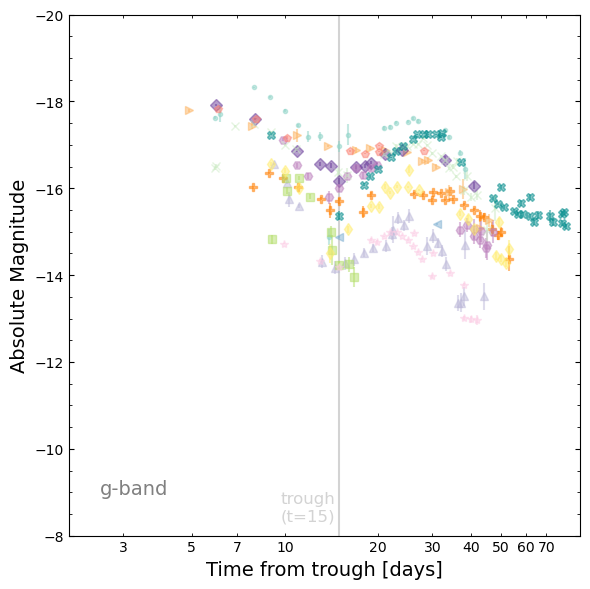

In [670]:
%matplotlib inline
markers = ['.','P','^','<','>','s','*','D','H','x','d','p','X']
plt.figure(figsize=(6,6))
ax = plt.subplot(111)
for i,df in enumerate(df_cut_list):
    sort_df = df.sort_values(by='norm_t')
    gband = ((sort_df['filter']=='ZTF_g')|(sort_df['filter']=='c'))&(sort_df['err']<=2.0)
    plt.errorbar(sort_df.loc[gband,'norm_t'], sort_df.loc[gband,'abs_mag'], sort_df.loc[gband, 'err'], 
                 color=colors[i],ls='',marker=markers[i], markersize=6, alpha=0.5)
    # plt.errorbar(sort_df.loc[gband,'norm_t']+10, sort_df.loc[gband,'abs_mag'], sort_df.loc[gband, 'mag_err_all'], color=colors[i],marker='.', markersize=5, alpha=0.5)

plt.annotate('g-band',xy=(0.06,0.08),xycoords='axes fraction',color='gray',fontsize=14)
plt.xscale('log')#,subs=[2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90])
plt.xlabel('Time from trough [days]', fontsize=14)
plt.axvline(x=15,color='lightgray',zorder=0)
plt.annotate('trough\n(t=15)',xy=(0.415, 0.03), xycoords='axes fraction',color='lightgray',fontsize=12)
plt.ylabel('Absolute Magnitude', fontsize=14)

# ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
locs = np.append( np.arange(1,8,2),np.arange(10,80,10))
ax.xaxis.set_minor_locator(mpl.ticker.FixedLocator(locs))
ax.xaxis.set_major_locator(mpl.ticker.NullLocator())

ax.xaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())
ax.tick_params(which="both", top=True, labeltop=False, bottom=True, labelbottom=True, left=True, right=True, direction="in")

plt.xlim(2, 90)
plt.ylim(-8,-20)
# plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(SAVE_DIR+'figures/abs_mag_logt_g.png')

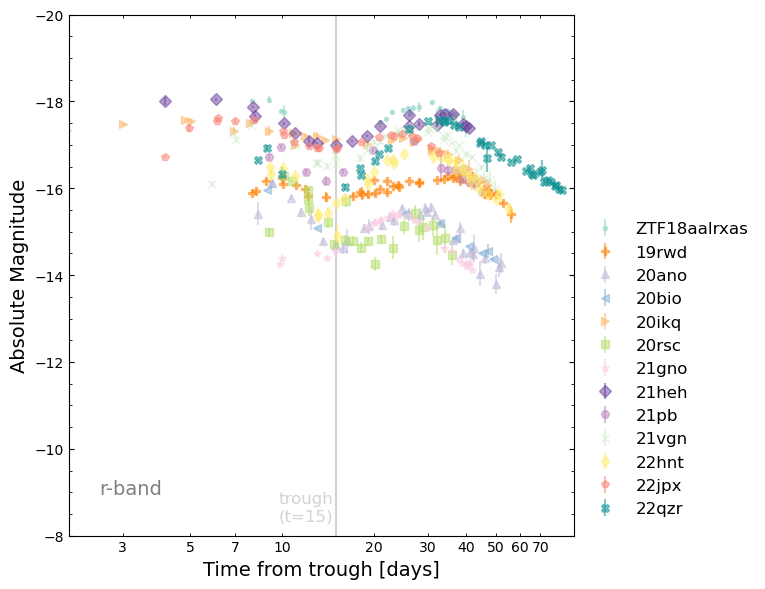

In [662]:
%matplotlib inline
# markers = ['.','H','^','<','>','s','*','D','P','x','d','p','X']
plt.figure(figsize=(7.75,6))
ax = plt.subplot(111)
for i,df in enumerate(df_cut_list):
    sort_df = df.sort_values(by='norm_t')
    rband = ((sort_df['filter']=='ZTF_r')|(sort_df['filter']=='o'))&(sort_df['err']<=2.0)
    ax.errorbar(sort_df.loc[rband,'norm_t'], sort_df.loc[rband,'abs_mag'], sort_df.loc[rband, 'err'], 
                color=colors[i], ls='', marker=markers[i], markersize=6, alpha=0.5, label=plot_names[i])
    # plt.errorbar(sort_df.loc[rband,'norm_t']+10, sort_df.loc[rband,'abs_mag'], sort_df.loc[rband, 'mag_err_all'], color=colors[i], marker='.', markersize=5, alpha=0.5)

plt.annotate('r-band',xy=(0.06,0.08),xycoords='axes fraction',color='gray',fontsize=14)
plt.xscale('log')#,subs=[2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90])
plt.xlabel('Time from trough [days]', fontsize=14)
plt.axvline(x=15,color='lightgray',zorder=0)
plt.annotate('trough\n(t=15)',xy=(0.415, 0.03), xycoords='axes fraction',color='lightgray',fontsize=12)
plt.ylabel('Absolute Magnitude', fontsize=14)

ax.yaxis.set_minor_locator(AutoMinorLocator())
locs = np.append( np.arange(1,8,2),np.arange(10,80,10))
ax.xaxis.set_minor_locator(mpl.ticker.FixedLocator(locs))
ax.xaxis.set_major_locator(mpl.ticker.NullLocator())

ax.xaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())
ax.tick_params(which="both", top=True, labeltop=False, bottom=True, labelbottom=True, left=True, right=True, direction="in")


plt.xlim(2, 90)
plt.ylim(-8,-20)
# plt.gca().invert_yaxis()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.32),frameon=False, fontsize=12)
plt.tight_layout()
plt.savefig(SAVE_DIR+'figures/abs_mag_logt_r.png')

In [663]:
############################
#    making t_1/2 plots
############################

In [664]:
#calculated earlier in notebook
bestfit_df[['SN_ID','t_half-r','a1_abs_mag-r']]

,SN_ID,t_half-r,a1_abs_mag-r
0,snztf18,5.315673,-18.046965
1,sn19rwd,3.490053,-16.248550
2,sn20ano,3.879967,-16.241535
3,sn20bio,3.628795,-16.134505
4,sn20ikq,8.283516,-17.575816
5,sn20rsc,3.655082,-16.043037
6,sn21gno,2.760791,-14.815750
7,sn21heh,4.899552,-18.206206
8,sn21pb,3.565412,-16.940105
9,sn21vgn,5.176878,-17.576960


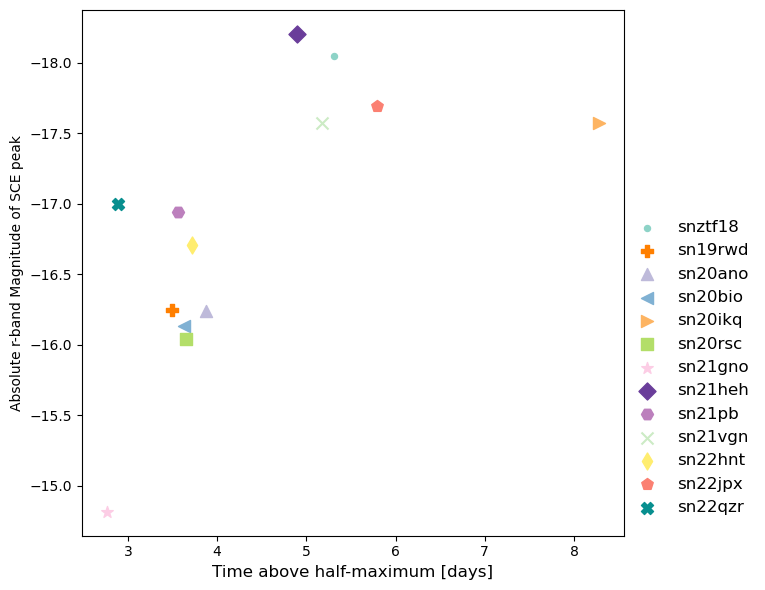

In [665]:
markers = ['.','P','^','<','>','s','*','D','H','x','d','p','X']
plt.figure(figsize=(7.75,6))
ax = plt.subplot(111)

# t-half and abs_mag of a1 come from bestfit_df
# mag error (& TODO:t-half error) come from df_sub_ls, df['mag_err_all']
for i,df in enumerate(df_sub_ls):
    plt.scatter(bestfit_df.loc[bestfit_df['SN_ID']==df_str_list[i], 't_half-r'],
                bestfit_df.loc[bestfit_df['SN_ID']==df_str_list[i], 'a1_abs_mag-r'],
                label=df_str_list[i], color=colors[i], marker=markers[i],s=75)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='center left', bbox_to_anchor=(0.985, 0.32),frameon=False, fontsize=12)
plt.xlabel('Time above half-maximum [days]', fontsize=12)
plt.ylabel('Absolute r-band Magnitude of SCE peak')
# plt.axvline(x=12, color='lightgray', label='12-day FBOT cut-off')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(SAVE_DIR+'figures/abs_mag_vs_t_half.png')

In [666]:
# reading in Ho23 FBOT Table
fbots = pd.read_csv('./data/fbot_table.csv',header=0, sep='\s+')

#dropping objects w/o redshift since need to convert to abs_mag w/ z->D
fbots = fbots.dropna(axis=0, ignore_index=True, subset='z')

#adding in classic FBOTs not already included
fbots.loc[len(df.index)] = [np.nan, np.nan, np.nan,np.nan,np.nan,np.nan,np.nan,'AT2018cow',np.nan, np.nan, 0.05,1.1+1.96, 0.04+0.12,np.nan,0.0141,'IIn/Ibn'] 

#converting z to distance w/ astropy
z = fbots.z.values * cu.redshift
fbots['d_calc'] = np.array(z.to(u.Mpc, cu.redshift_distance(WMAP9, kind="comoving")))

#calculate absolute mag from distance and app_mag (Pmag) which is g-band here
fbots['abs_mag_g'] = fbots['Pmag'] - 2.5*np.log10(((fbots['d_calc']*1e6)/10)**2)
fbots['Ho23_abs_mag'] = fbots['Pmag'] - 5*np.log10((fbots['d_calc']*1e6)/10) + 2.5*np.log10(1+fbots['z'])
# (fbots['abs_mag_g']-fbots['Ho23_abs_mag']).describe() #see the difference b/w my conversion equation and the one used in Ho23

fbots.loc[fbots['IAU']=='AT2018cow','Ho23_abs_mag'] = -20.87
fbots.loc[fbots['IAU']=='AT2018cow','abs_mag_g'] = -20.87 #tacking onto my calc'd absmag_g column for plotting sakes
fbots

,ZTF,RAh,RAm,RAs,DE-,DEd,DEs,IAU,MJD,Pmag,e_Pmag,t0.5_g,e_t0.5_g,g-r,z,Class,d_calc,abs_mag_g,Ho23_abs_mag
0,18aakuewf,16.0,14.0,22.65,35.0,55.0,4.4,SN2018bcc,58230.38,17.46,0.04,9.10,0.40,-0.3,0.06360,Ibn,271.241505,-19.706781,-19.639835
1,18abfcmjw,17.0,36.0,46.74,50.0,32.0,52.1,SN2019dge,58583.16,18.40,0.02,6.10,0.20,-0.2,0.02130,Ib,91.693559,-16.411694,-16.388811
2,18abukavn,16.0,43.0,48.20,41.0,2.0,43.3,SN2018gep,58374.22,15.91,0.01,9.30,0.20,-0.4,0.03154,Ic-BL,135.471494,-19.749240,-19.715524
3,18abvkmgw,0.0,37.0,26.87,15.0,0.0,51.2,SN2018ghd,58377.35,18.49,0.03,9.50,0.90,-0.1,0.03923,Ib,168.216900,-17.639348,-17.597569
4,18abvkwla,2.0,0.0,15.19,16.0,47.0,57.3,AT2018lug,58374.41,19.34,0.05,4.00,0.10,-0.6,0.27140,Feat.;RL,1102.094673,-20.871095,-20.610389
5,18abwkrbl,2.0,16.0,15.58,28.0,35.0,28.6,SN2018gjx,58379.44,15.58,0.01,7.40,0.10,-0.2,0.00999,IIb,43.111369,-17.592959,-17.582166
6,19aapfmki,14.0,5.0,43.56,9.0,30.0,56.6,SN2019deh,58587.33,17.22,0.02,10.70,0.70,-0.2,0.05469,Ibn,233.706630,-19.623355,-19.565543
7,19aatoboa,12.0,25.0,40.57,44.0,44.0,48.8,AT2019esf,58609.22,18.84,0.03,7.20,0.60,-0.4,0.07580,NaN,322.387120,-18.701888,-18.622560
8,19abfarpa,11.0,7.0,9.56,57.0,6.0,3.2,AT2019kyw,58676.18,18.28,0.04,11.90,0.50,-0.2,0.07400,NaN,314.859197,-19.210582,-19.133071
9,19abobxik,0.0,43.0,43.12,37.0,3.0,38.9,SN2019myn,58706.45,18.84,0.02,9.50,0.80,-0.1,0.10000,Ibn,422.982356,-19.291611,-19.188130


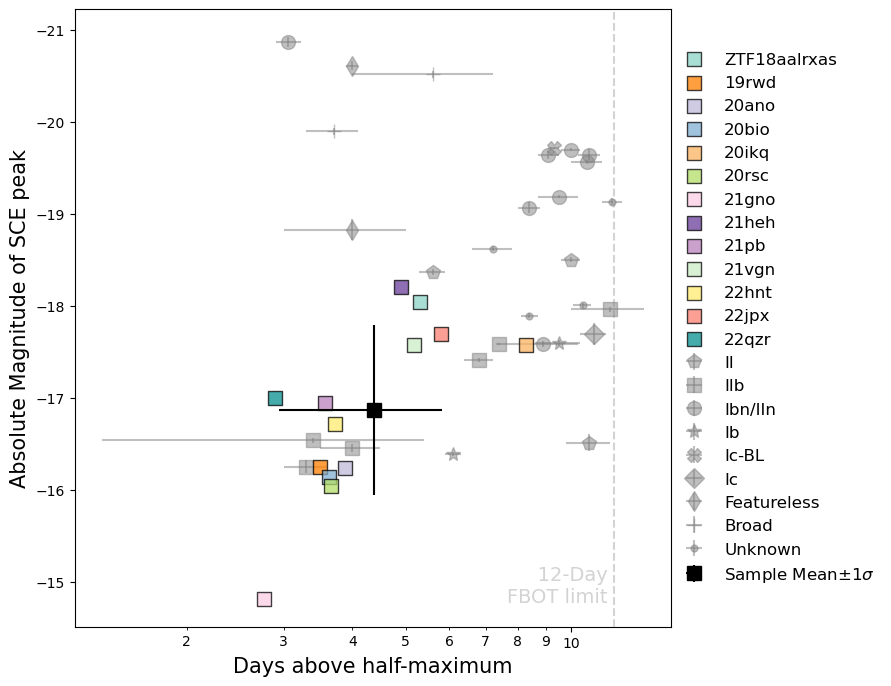

In [668]:
from matplotlib.ticker import FormatStrFormatter
fig = plt.figure(figsize=(9,7))
ax = plt.subplot(111)

ii = (fbots['Class']=='II')|(fbots['Class']=='II?')
iib = (fbots['Class']=='IIb')
iinb = (fbots['Class']=='Ibn')|(fbots['Class']=='IIn')|(fbots['Class']=='IIn?')|(fbots['Class']=='IIn/Ibn')
ib = (fbots['Class']=='Ib')
icbl = (fbots['Class']=='Ic-BL')
ic = (fbots['Class']=='Ic')
fless = (fbots['Class']=='Feat.;RL')|(fbots['Class']=='Feat.')
broad = (fbots['Class']=='UB')|(fbots['Class']=='UB;RL')
unknow = (fbots['Class'].isna())

types = [ii,iib,iinb,ib,icbl,ic,fless,broad,unknow]
markers = ['p','s','o','*','X','D','d','+', '.']
labels = ['II','IIb','Ibn/IIn','Ib','Ic-BL','Ic','Featureless','Broad','Unknown']

#plotting anna's
for i in range(len(types)):
    plt.errorbar(fbots.loc[types[i],'t0.5_g'], fbots.loc[types[i],'Ho23_abs_mag'], yerr=fbots.loc[types[i],'e_Pmag'], xerr=fbots.loc[types[i],'e_t0.5_g'],
                 ls='', marker=markers[i], markersize='10', label=labels[i], alpha=0.5, color='gray')
    
#plotting my data
for i,df in enumerate(df_sub_ls):
    plt.scatter(bestfit_df.loc[bestfit_df['SN_ID']==df_str_list[i], 't_half-r'],
                bestfit_df.loc[bestfit_df['SN_ID']==df_str_list[i], 'a1_abs_mag-r'],
                label=plot_names[i], facecolor=colors[i],edgecolor='black', marker='s',s=95, alpha=0.75,zorder=10)
    
#plotting mean t_1/2 and mean abs_mag
plt.errorbar(stats_df.loc[stats_df['param']=='t_half-r', 'mean'],
             stats_df.loc[stats_df['param']=='a1_abs_mag-r', 'mean'],
             xerr=stats_df.loc[stats_df['param']=='t_half-r', 'std'],
             yerr=stats_df.loc[stats_df['param']=='a1_abs_mag-r', 'std'],
             label='Sample Mean$\pm 1 \sigma$',
             marker='s', ls='', ecolor='black', markerfacecolor='black', markeredgecolor='black', markersize=10,zorder=50)

plt.gca().invert_yaxis()
plt.axvline(x=12,color='lightgray',ls='dashed')
plt.xscale('log')
ax.xaxis.set_minor_formatter(FormatStrFormatter("%.i"))
ax.xaxis.set_major_formatter(FormatStrFormatter("%.i"))
plt.annotate('     12-Day\nFBOT limit',xy=(0.725,0.04),xycoords='axes fraction',color='lightgray',fontsize=14)


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='center left', bbox_to_anchor=(0.985, 0.5),frameon=False, fontsize=12)
plt.xlabel('Days above half-maximum', fontsize=15)
plt.ylabel('Absolute Magnitude of SCE peak', fontsize=15)
plt.tight_layout()
plt.savefig(SAVE_DIR+'figures/abs_mag_t_half_Ho23_overlay.png')
#note that my points are calculated w/ r-band and Ho23 calculated w/ g-band

In [533]:
fbots.loc[(fbots['IAU']=='SN2020ano')|(fbots['IAU']=='SN2020ikq')|(fbots['IAU']=='SN2020rsc'),['IAU','t0.5_g','e_t0.5_g','abs_mag_g','Ho23_abs_mag']]

,IAU,t0.5_g,e_t0.5_g,abs_mag_g,Ho23_abs_mag
15,SN2020ano,3.4,2.0,-16.571022,-16.537739
18,SN2020ikq,11.8,1.8,-18.006175,-17.961506
24,SN2020rsc,3.3,0.3,-16.282767,-16.249305


In [534]:
bestfit_df.loc[(bestfit_df['SN_ID']=='sn20ano')|(bestfit_df['SN_ID']=='sn20ikq')|(bestfit_df['SN_ID']=='sn20rsc'), ['SN_ID','t_half-r','a1_abs_mag-r']]

,SN_ID,t_half-r,a1_abs_mag-r
2,sn20ano,3.879967,-16.241535
4,sn20ikq,8.283516,-17.575816
5,sn20rsc,3.655082,-16.043037


In [671]:
#calculate t_1/2 from individual mcmc fits, 

def calc_t_half(df_sub, df_str):
    df_sub = df_sub.sort_values(by='norm_t')
    ###gband
    gband = (df_sub['filter']=='ZTF_g') | (df_sub['filter']=='c')
    
    min_t = df_sub.loc[gband,'norm_t'].min()
    best_df = bestfit_df.loc[bestfit_df['SN_ID']==df_str]

    #calc time above half max for SCE peak
    ta1 = best_df.a1_g                    #time of a1, SCE peak
    taa1 = best_df['a2g-a1g']/2 + ta1     #time halfway b/w a1 and a2
    tba1 = ta1 - (ta1-min_t)/2            #time halfway b/w start and a1
    t_half = (taa1-tba1).item()
    #add to bestfit_df
    bestfit_df.loc[bestfit_df['SN_ID']==df_str, 't_half-g'] = t_half

    ###rband
    rband = (df_sub['filter']=='ZTF_r') | (df_sub['filter']=='o')
    
    min_t = df_sub.loc[rband,'norm_t'].min()
    best_df = bestfit_df.loc[bestfit_df['SN_ID']==df_str]

    #calc time above half max for SCE peak
    ta1 = best_df.a1_r                    #time of a1, SCE peak
    taa1 = best_df['a2r-a1r']/2 + ta1     #time halfway b/w a1 and a2
    tba1 = ta1 - (ta1-min_t)/2            #time halfway b/w start and a1
    t_half = (taa1-tba1).item()
    #add to bestfit_df
    bestfit_df.loc[bestfit_df['SN_ID']==df_str, 't_half-r'] = t_half

    # # calc abs mag of SCE peak (a1)
    # x_list = np.arange(min_t,df_sub.loc[rband,'norm_t'].max(),0.01)
    # best = best_df[['m1_r','m2_r','m3_r','b2_r','a1_r','a2_r','log_f_r']].iloc[0].to_numpy()
    # a1_index = np.abs(x_list - ta1.values).argmin()
    # app_mag_a1 = np.array([model(best, v, r1=r1_bool_dict['r'][df_str]) for v in x_list])[a1_index] + mag_conversion_df.loc[mag_conversion_df['sn']==df_str].norm_mag_shift.iloc[0]
    # abs_mag_a1 = (app_mag_a1 - mag_conversion_df.loc[mag_conversion_df['sn']==df_str].mag_conversion.iloc[0] - 
    #               mag_conversion_df.loc[mag_conversion_df['sn']==df_str].ext_r.iloc[0])
    # bestfit_df.loc[bestfit_df['SN_ID']==df_str, 'a1_abs_mag-r'] = abs_mag_a1
    
    return #t_half, abs_mag_a1

In [676]:
for i,df in enumerate(df_sub_ls):
    calc_t_half(df, df_str_list[i])
bestfit_df['t_half_(g-r)'] = bestfit_df['t_half-g'] - bestfit_df['t_half-r']
bestfit_df[['SN_ID', 't_half-g','t_half-r','t_half_(g-r)']]

,SN_ID,t_half-g,t_half-r,t_half_(g-r)
0,snztf18,3.565871,5.315673,-1.749802
1,sn19rwd,3.647605,3.490053,0.157552
2,sn20ano,2.714818,3.879967,-1.165149
3,sn20bio,3.851399,3.628795,0.222604
4,sn20ikq,7.887164,8.283516,-0.396351
5,sn20rsc,4.303204,3.655082,0.648122
6,sn21gno,3.015144,2.760791,0.254353
7,sn21heh,8.527272,4.899552,3.627720
8,sn21pb,NaN,3.565412,NaN
9,sn21vgn,5.779407,5.176878,0.602529


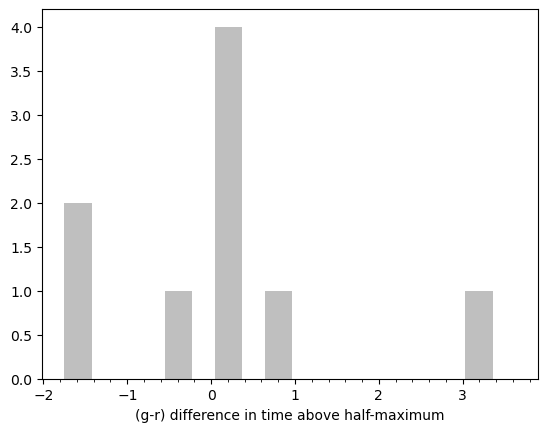

In [692]:
ax = plt.subplot(111)
plt.hist(bestfit_df['t_half_(g-r)'],bins=9,color='gray', alpha=0.5,width=0.33)
plt.xlabel('(g-r) difference in time above half-maximum')
ax.xaxis.set_minor_locator(AutoMinorLocator())

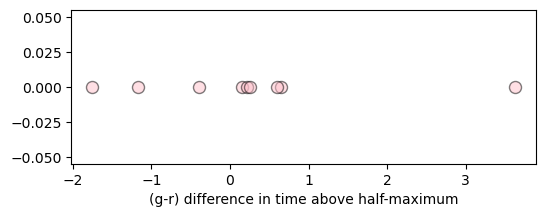

In [722]:
plt.figure(figsize=(6,2))
plt.scatter(bestfit_df.loc[bestfit_df['t_half_(g-r)'].notna(),'t_half_(g-r)'], [0]*9, alpha=0.5, facecolor='pink', edgecolor='black',s=75)
plt.xlabel('(g-r) difference in time above half-maximum')
ax.xaxis.set_minor_locator(AutoMinorLocator())

In [723]:
bestfit_df['t_half_(g-r)'].describe()

count    9.000000
mean     0.244620
std      1.505010
min     -1.749802
25%     -0.396351
50%      0.222604
75%      0.602529
max      3.627720
Name: t_half_(g-r), dtype: float64